In [104]:
#Importing the libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor

from scipy.stats import zscore

import statsmodels.api         as     sm
from   statsmodels.formula.api import ols

from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline

In [105]:
label_encoder = preprocessing.LabelEncoder()

In [106]:
class HandleData:   
    
    targetcolumn_filename = 'fund_specs.csv'
    target_column = 'greatstone_rating'
    id_column = 'fund_id'
    
    def __init__(self, filename):
        self.filename = filename
        self.df = []
        self.data_correlation = []
        self.correlated_cols_list = []
        self.checked_correlation = False
        self.cols_updated_list = []
        self.df_scaled = []
    
    def read_data(self):
        self.df = pd.read_csv(self.filename)
#         print(df.info())
        return self.df.head()

    def drop_columns(self, columns) :
        self.df.drop(columns, axis = 1, inplace = True)
        
    def handle_categorydata(self, categorical_columns_list) :
        for col in categorical_columns_list :
            if col != 'tag' or col != self.target_column :
                if self.df[col].dtype == 'object' :
                    self.df[col].fillna(self.df[col].mode()[0], inplace = True)
                    self.df[col] = label_encoder.fit_transform(self.df[col])
                    
    def describe_data(self):
        for col in self.df.columns :
            if col != self.id_column and self.df[col].dtype == 'object' :
                self.df[col].replace(regex = True, inplace = True, to_replace = '[,]', value = '')
                self.df[col] = self.df[col].astype('float64')
        return self.df.describe().transpose()
    
    def show_correlation(self, figsize):
        if self.target_column not in self.df.columns :
            df_temp = pd.read_csv(self.targetcolumn_filename)
            self.df[self.target_column] = df_temp[self.target_column]
        self.data_correlation = self.df.corr()
        plt.figure(figsize = figsize)
        sns.heatmap(self.data_correlation, annot = True)
        plt.show()
        
    def select_columns(self):
        self.checked_correlation = True
        self.correlated_cols_list.clear()
        for col in self.df.columns:
            if col != self.target_column and col != self.id_column:
                if (self.data_correlation[col][self.target_column] >= 0.1) or (self.data_correlation[col][self.target_column] <= -0.1) :
                    self.correlated_cols_list.append(col)
        for target in self.correlated_cols_list :
                for col in self.df.columns:
                    if col != self.target_column and col != self.id_column and col not in self.correlated_cols_list :
                        if (self.data_correlation[col][target] >= 0.5) or (self.data_correlation[col][target] <= -0.5) :
                            self.cols_updated_list.append(col)
        self.correlated_cols_list.extend(self.cols_updated_list)
        return self.correlated_cols_list
    
    def handle_outliers(self) :
        df_temp = self.df.copy(deep = True)
        Q1 = df_temp.quantile(0.25)
        Q3 = df_temp.quantile(0.75)
        IQR = Q3 -Q1
        
        for i,j in zip(np.where(df_temp < Q1 - 1.5 * IQR)[0], np.where(df_temp < Q1 - 1.5 * IQR)[1]) :
            whisker = Q1 - 1.5 * IQR
            df_temp.iloc[i, j] = whisker[j]
            
        for i,j in zip(np.where(df_temp > Q3 + 1.5 * IQR)[0], np.where(df_temp > Q3 + 1.5 * IQR)[1]) :
            whisker = Q3 + 1.5 * IQR
            df_temp.iloc[i, j] = whisker[j]
        
        for col in self.df.columns :
            if col != 'tag' or col != self.target_column :
                self.df[col] = df_temp[col]
    
    def check_correlation(self):
        if not self.checked_correlation :
            self.select_columns()
        if len(self.correlated_cols_list) > 0:
            return True
        else:
            return False
    
    def handle_missingvalues(self):
        for col in self.df.columns :
            if col != self.target_column and col != self.id_column and col != 'tag' :
                self.df[col].fillna(self.df[col].mean(), inplace = True)

        
    def show_pairwise(self) :
        drop_cols = ['tag', 'fund_id', 'greatstone_rating']
        can_drop_cols = []
        for col in drop_cols :
            if col in self.df.columns :
                can_drop_cols.append(col)
        self.df_scaled = self.df.drop(can_drop_cols, axis = 1).apply(zscore)
        self.df_scaled['greatstone_rating'] = self.df['greatstone_rating']
        self.df_scaled = self.df_scaled.dropna()
        np.set_printoptions(precision=4)
        for column in self.df_scaled.columns :
            if(column != 'greatstone_rating') :
                self.TestANOVA(column, 'greatstone_rating', column, 'greatstone_rating')
        
    def TestANOVA(self, col_0, col_1, col_name_0, col_name_1) :
        sns.boxplot(x = col_1, y = col_0, data = self.df_scaled)
        plt.title(("Relation between {0} and {1}").format(col_0, col_1))
        plt.show()
        df0_val = self.df_scaled[col_0].values
        df1_val = self.df_scaled[col_1].values
        for i in range(10):
            col_name_0 = col_name_0.replace(str(i),'')
        if col_name_0 == 'yield' :
            col_name_0 = 'yield_col'
        df_temp = pd.DataFrame({col_name_0 : df0_val, col_name_1 : df1_val})
    #     print(df.head(10))
        formula = col_name_0+" ~ "+col_name_1
        mod = ols(formula = formula, data = df_temp).fit()
        aov_table = sm.stats.anova_lm(mod, typ=2)
        print(aov_table)
        print(pairwise_tukeyhsd(df_temp[col_name_0], df_temp[col_name_1]))

In [107]:
handle_data_references = []

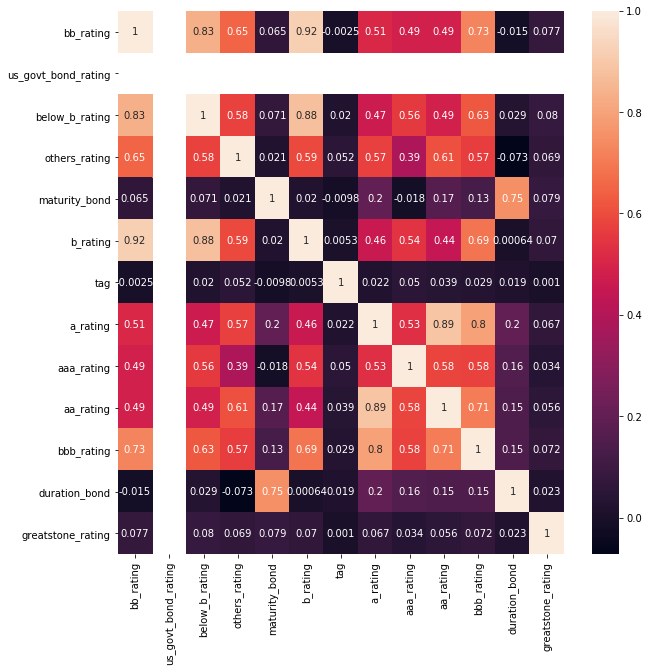

C:\Users\home\Anaconda3\lib\site-packages\scipy\stats\stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


ValueError: min() arg is an empty sequence

In [108]:
handle_bondratingsdata = HandleData('bond_ratings.csv')
handle_data_references.append(handle_bondratingsdata)
handle_bondratingsdata.read_data()
handle_bondratingsdata.describe_data()
handle_bondratingsdata.handle_outliers()
handle_bondratingsdata.show_correlation(figsize = (10,10))
handle_bondratingsdata.handle_missingvalues()
handle_bondratingsdata.describe_data()
handle_bondratingsdata.show_pairwise()
if handle_bondratingsdata.check_correlation():
    print("Has correlation")
    print(handle_bondratingsdata.correlated_cols_list)
else:
    print('No correlation')


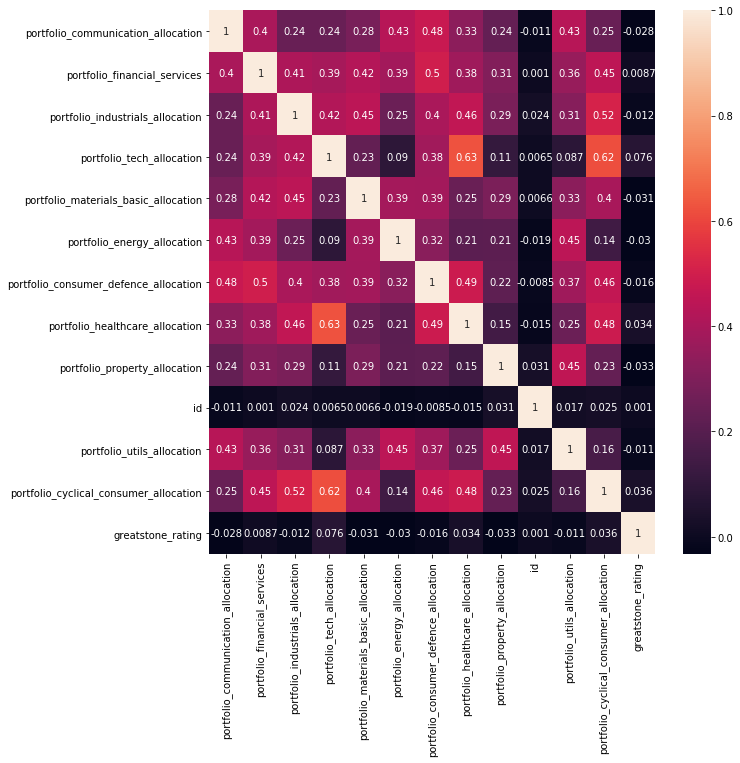

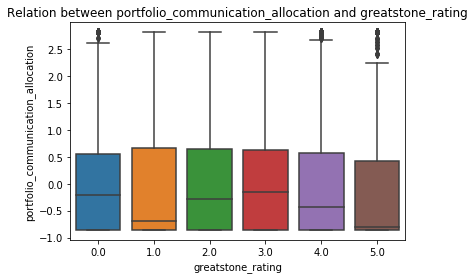

                         sum_sq       df          F    PR(>F)
greatstone_rating     15.247081      1.0  15.297993  0.000092
Residual           19931.446509  19998.0        NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0     0.04    0.9 -0.0686  0.1485  False
   0.0    2.0   0.0851 0.0676 -0.0034  0.1736  False
   0.0    3.0   0.0782 0.0874 -0.0061  0.1625  False
   0.0    4.0  -0.0039    0.9 -0.0915  0.0837  False
   0.0    5.0   -0.104 0.0511 -0.2083  0.0003  False
   1.0    2.0   0.0451 0.6666 -0.0431  0.1333  False
   1.0    3.0   0.0382 0.7603 -0.0458  0.1222  False
   1.0    4.0  -0.0439 0.6817 -0.1312  0.0434  False
   1.0    5.0   -0.144 0.0011  -0.248 -0.0399   True
   2.0    3.0  -0.0069    0.9 -0.0626  0.0488  False
   2.0    4.0   -0.089  0.001 -0.1495 -0.0285   True
   2.0    5.0  -0.1891  0.001  -0.272 -0.1062   True
   3.0    4.0  -0.0

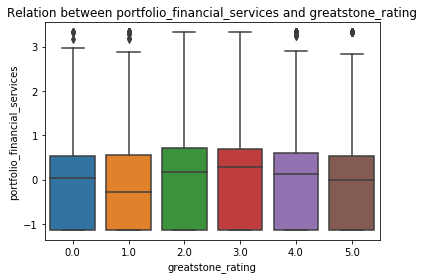

                         sum_sq       df         F   PR(>F)
greatstone_rating      1.505278      1.0  1.517388  0.21803
Residual           19838.387282  19998.0       NaN      NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   -0.017    0.9 -0.1252  0.0912  False
   0.0    2.0   0.1558  0.001  0.0676  0.2439   True
   0.0    3.0   0.1798  0.001  0.0958  0.2638   True
   0.0    4.0   0.0785 0.1062 -0.0087  0.1658  False
   0.0    5.0    0.033    0.9 -0.0709  0.1369  False
   1.0    2.0   0.1728  0.001  0.0849  0.2607   True
   1.0    3.0   0.1968  0.001  0.1131  0.2805   True
   1.0    4.0   0.0955 0.0217  0.0085  0.1825   True
   1.0    5.0     0.05 0.7158 -0.0537  0.1537  False
   2.0    3.0    0.024 0.7955 -0.0314  0.0795  False
   2.0    4.0  -0.0773 0.0036 -0.1375  -0.017   True
   2.0    5.0  -0.1228  0.001 -0.2054 -0.0402   True
   3.0    4.0  -0.1013  0

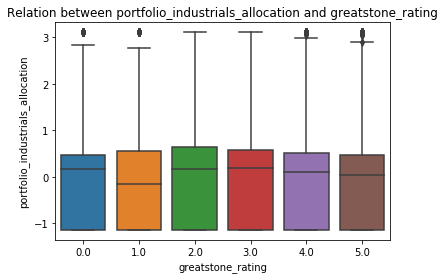

                         sum_sq       df         F    PR(>F)
greatstone_rating      2.720187      1.0  2.698531  0.100456
Residual           20158.483814  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.1592  0.001 -0.2684 -0.0501   True
   0.0    2.0   0.0174    0.9 -0.0716  0.1064  False
   0.0    3.0   0.0072    0.9 -0.0776  0.0919  False
   0.0    4.0  -0.0552 0.4761 -0.1432  0.0329  False
   0.0    5.0  -0.0999 0.0724 -0.2048  0.0049  False
   1.0    2.0   0.1766  0.001  0.0879  0.2653   True
   1.0    3.0   0.1664  0.001  0.0819  0.2509   True
   1.0    4.0   0.1041 0.0095  0.0163  0.1919   True
   1.0    5.0   0.0593 0.5762 -0.0453  0.1639  False
   2.0    3.0  -0.0102    0.9 -0.0662  0.0458  False
   2.0    4.0  -0.0726 0.0089 -0.1334 -0.0117   True
   2.0    5.0  -0.1173  0.001 -0.2007  -0.034   True
   3.0    4.0  -0.0623

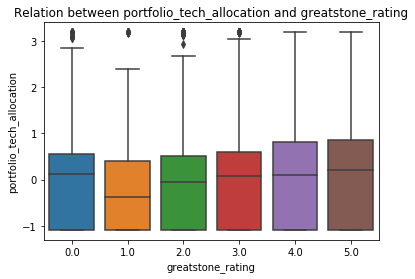

                         sum_sq       df           F        PR(>F)
greatstone_rating    114.617468      1.0  116.186058  5.134295e-27
Residual           19728.013531  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.2053  0.001 -0.3133 -0.0973   True
   0.0    2.0  -0.0295    0.9 -0.1175  0.0585  False
   0.0    3.0   0.0673 0.1992 -0.0166  0.1512  False
   0.0    4.0   0.1077 0.0057  0.0206  0.1948   True
   0.0    5.0   0.1875  0.001  0.0837  0.2912   True
   1.0    2.0   0.1758  0.001  0.0881  0.2635   True
   1.0    3.0   0.2726  0.001   0.189  0.3562   True
   1.0    4.0    0.313  0.001  0.2262  0.3998   True
   1.0    5.0   0.3928  0.001  0.2893  0.4963   True
   2.0    3.0   0.0968  0.001  0.0414  0.1522   True
   2.0    4.0   0.1372  0.001   0.077  0.1974   True
   2.0    5.0    0.217  0.001  0.1346  0.2994   True
   3

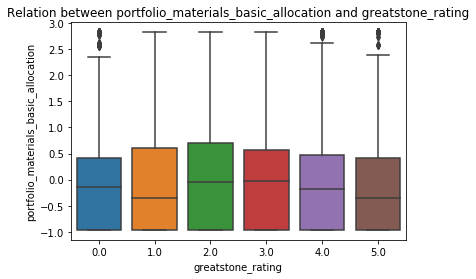

                         sum_sq       df          F    PR(>F)
greatstone_rating     18.463529      1.0  18.509189  0.000017
Residual           19948.667536  19998.0        NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.0968 0.1123 -0.0117  0.2054  False
   0.0    2.0   0.1544  0.001   0.066  0.2429   True
   0.0    3.0   0.1151 0.0014  0.0308  0.1994   True
   0.0    4.0   0.0214    0.9 -0.0662   0.109  False
   0.0    5.0  -0.0632 0.5118 -0.1674  0.0411  False
   1.0    2.0   0.0576 0.4281 -0.0306  0.1458  False
   1.0    3.0   0.0183    0.9 -0.0657  0.1023  False
   1.0    4.0  -0.0754  0.135 -0.1627  0.0119  False
   1.0    5.0    -0.16  0.001  -0.264  -0.056   True
   2.0    3.0  -0.0393 0.3348  -0.095  0.0163  False
   2.0    4.0   -0.133  0.001 -0.1935 -0.0725   True
   2.0    5.0  -0.2176  0.001 -0.3005 -0.1347   True
   3.0    4.0  -0.0

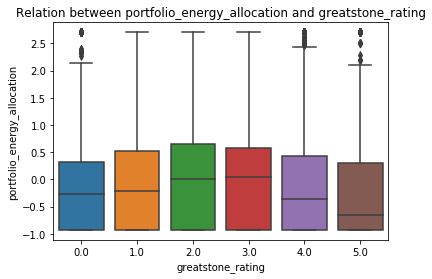

                         sum_sq       df          F    PR(>F)
greatstone_rating     17.819013      1.0  17.907164  0.000023
Residual           19899.556917  19998.0        NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.1361 0.0045   0.028  0.2443   True
   0.0    2.0   0.2177  0.001  0.1295  0.3058   True
   0.0    3.0   0.2124  0.001  0.1284  0.2964   True
   0.0    4.0   0.0665 0.2505 -0.0207  0.1537  False
   0.0    5.0  -0.0659  0.463 -0.1698   0.038  False
   1.0    2.0   0.0815 0.0872 -0.0064  0.1694  False
   1.0    3.0   0.0763  0.098 -0.0075    0.16  False
   1.0    4.0  -0.0696 0.2013 -0.1566  0.0173  False
   1.0    5.0   -0.202  0.001 -0.3057 -0.0983   True
   2.0    3.0  -0.0053    0.9 -0.0607  0.0502  False
   2.0    4.0  -0.1512  0.001 -0.2114 -0.0909   True
   2.0    5.0  -0.2835  0.001 -0.3661  -0.201   True
   3.0    4.0  -0.1

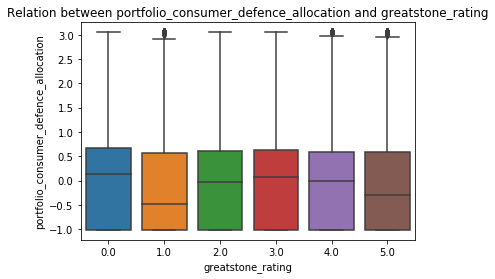

                         sum_sq       df         F    PR(>F)
greatstone_rating      4.901002      1.0  4.950876  0.026089
Residual           19796.545549  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.1652  0.001 -0.2734  -0.057   True
   0.0    2.0  -0.0913 0.0376 -0.1795 -0.0031   True
   0.0    3.0  -0.0434 0.6594 -0.1274  0.0407  False
   0.0    4.0  -0.1228  0.001 -0.2101 -0.0355   True
   0.0    5.0  -0.1244 0.0085 -0.2284 -0.0205   True
   1.0    2.0   0.0739 0.1576  -0.014  0.1619  False
   1.0    3.0   0.1218  0.001  0.0381  0.2056   True
   1.0    4.0   0.0424 0.7067 -0.0446  0.1294  False
   1.0    5.0   0.0408 0.8621  -0.063  0.1445  False
   2.0    3.0   0.0479  0.136 -0.0076  0.1034  False
   2.0    4.0  -0.0315 0.6492 -0.0918  0.0288  False
   2.0    5.0  -0.0332 0.8484 -0.1158  0.0495  False
   3.0    4.0  -0.0794

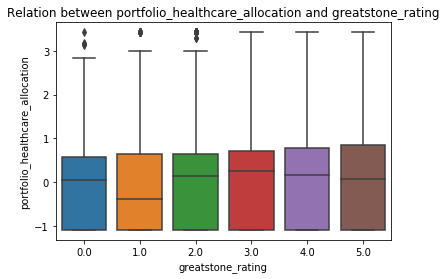

                         sum_sq       df          F    PR(>F)
greatstone_rating     22.985813      1.0  22.990001  0.000002
Residual           19994.357194  19998.0        NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0504 0.7459 -0.1592 0.0584  False
   0.0    2.0   0.0852 0.0682 -0.0035 0.1738  False
   0.0    3.0   0.1353  0.001  0.0508 0.2198   True
   0.0    4.0   0.1009 0.0135  0.0131 0.1886   True
   0.0    5.0   0.1005 0.0675  -0.004  0.205  False
   1.0    2.0   0.1356  0.001  0.0472  0.224   True
   1.0    3.0   0.1857  0.001  0.1015 0.2699   True
   1.0    4.0   0.1513  0.001  0.0638 0.2388   True
   1.0    5.0    0.151  0.001  0.0467 0.2553   True
   2.0    3.0   0.0501 0.1071 -0.0057 0.1059  False
   2.0    4.0   0.0157    0.9 -0.0449 0.0763  False
   2.0    5.0   0.0154    0.9 -0.0677 0.0984  False
   3.0    4.0  -0.0344 0.4635 -0.0

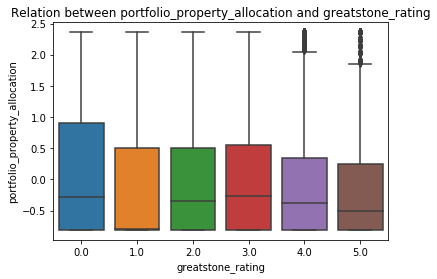

                         sum_sq       df          F    PR(>F)
greatstone_rating     21.185204      1.0  21.121115  0.000004
Residual           20058.680771  19998.0        NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.1252 0.0136 -0.2341 -0.0162   True
   0.0    2.0  -0.1063 0.0085 -0.1951 -0.0174   True
   0.0    3.0  -0.0782 0.0894 -0.1628  0.0065  False
   0.0    4.0  -0.1498  0.001 -0.2377 -0.0618   True
   0.0    5.0  -0.1816  0.001 -0.2863 -0.0769   True
   1.0    2.0   0.0189    0.9 -0.0697  0.1074  False
   1.0    3.0    0.047 0.5924 -0.0374  0.1313  False
   1.0    4.0  -0.0246    0.9 -0.1122   0.063  False
   1.0    5.0  -0.0565 0.6195 -0.1609   0.048  False
   2.0    3.0   0.0281  0.682 -0.0278   0.084  False
   2.0    4.0  -0.0435  0.319 -0.1042  0.0172  False
   2.0    5.0  -0.0753  0.102 -0.1585  0.0079  False
   3.0    4.0  -0.0

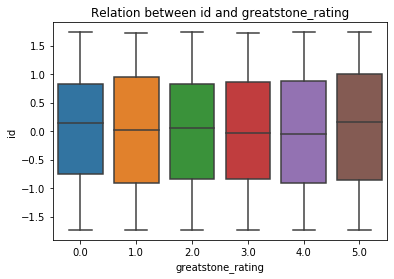

                         sum_sq       df         F   PR(>F)
greatstone_rating      0.021221      1.0  0.021147  0.88438
Residual           20068.025750  19998.0       NaN      NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0524 0.7177 -0.1614 0.0566  False
   0.0    2.0  -0.0505 0.5728 -0.1394 0.0383  False
   0.0    3.0  -0.0655 0.2355 -0.1501 0.0192  False
   0.0    4.0  -0.0686 0.2263 -0.1566 0.0193  False
   0.0    5.0   0.0434 0.8262 -0.0613 0.1482  False
   1.0    2.0   0.0019    0.9 -0.0867 0.0905  False
   1.0    3.0  -0.0131    0.9 -0.0975 0.0713  False
   1.0    4.0  -0.0162    0.9 -0.1039 0.0714  False
   1.0    5.0   0.0958 0.0937 -0.0086 0.2003  False
   2.0    3.0   -0.015    0.9 -0.0709 0.0409  False
   2.0    4.0  -0.0181    0.9 -0.0789 0.0426  False
   2.0    5.0    0.094 0.0163  0.0107 0.1772   True
   3.0    4.0  -0.0032    0.9 -0.0576 0.

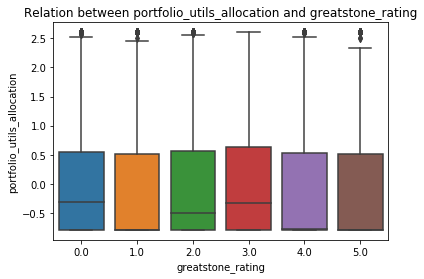

                         sum_sq       df         F    PR(>F)
greatstone_rating      2.465730      1.0  2.446078  0.117835
Residual           20158.666712  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.1151 0.0318 -0.2243  -0.006   True
   0.0    2.0  -0.0301    0.9  -0.119  0.0589  False
   0.0    3.0   0.0393  0.745 -0.0454  0.1241  False
   0.0    4.0  -0.0672   0.25 -0.1552  0.0209  False
   0.0    5.0  -0.1038 0.0542 -0.2087  0.0011  False
   1.0    2.0   0.0851 0.0691 -0.0036  0.1737  False
   1.0    3.0   0.1545  0.001    0.07   0.239   True
   1.0    4.0    0.048 0.6091 -0.0398  0.1358  False
   1.0    5.0   0.0113    0.9 -0.0933   0.116  False
   2.0    3.0   0.0694 0.0055  0.0135  0.1254   True
   2.0    4.0  -0.0371  0.506 -0.0979  0.0238  False
   2.0    5.0  -0.0737 0.1181 -0.1571  0.0096  False
   3.0    4.0  -0.1065

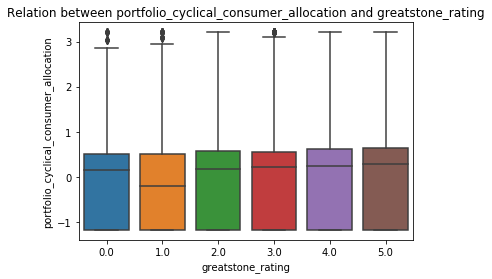

                         sum_sq       df          F        PR(>F)
greatstone_rating     25.882401      1.0  26.013214  3.421858e-07
Residual           19897.436336  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0749 0.3627 -0.1835 0.0337  False
   0.0    2.0   0.0545 0.4956  -0.034 0.1429  False
   0.0    3.0   0.0692  0.178 -0.0151 0.1535  False
   0.0    4.0   0.0744 0.1492 -0.0132 0.1619  False
   0.0    5.0   0.1277 0.0064  0.0235  0.232   True
   1.0    2.0   0.1294  0.001  0.0412 0.2176   True
   1.0    3.0   0.1441  0.001  0.0601 0.2282   True
   1.0    4.0   0.1493  0.001   0.062 0.2366   True
   1.0    5.0   0.2026  0.001  0.0986 0.3067   True
   2.0    3.0   0.0148    0.9 -0.0409 0.0704  False
   2.0    4.0   0.0199    0.9 -0.0406 0.0804  False
   2.0    5.0   0.0733 0.1185 -0.0096 0.1562  False
   3.0    4.0   0.0051

In [109]:
handle_fundallocationsdata = HandleData('fund_allocations.csv')
handle_data_references.append(handle_fundallocationsdata)
handle_fundallocationsdata.read_data()
handle_fundallocationsdata.describe_data()
handle_fundallocationsdata.handle_outliers()
handle_fundallocationsdata.show_correlation(figsize = (10,10))
handle_fundallocationsdata.handle_missingvalues()
handle_fundallocationsdata.describe_data()
handle_fundallocationsdata.show_pairwise()
if handle_fundallocationsdata.check_correlation():
    print("Has correlation")
    print(handle_fundallocationsdata.correlated_cols_list)
else:
    print('No correlation')

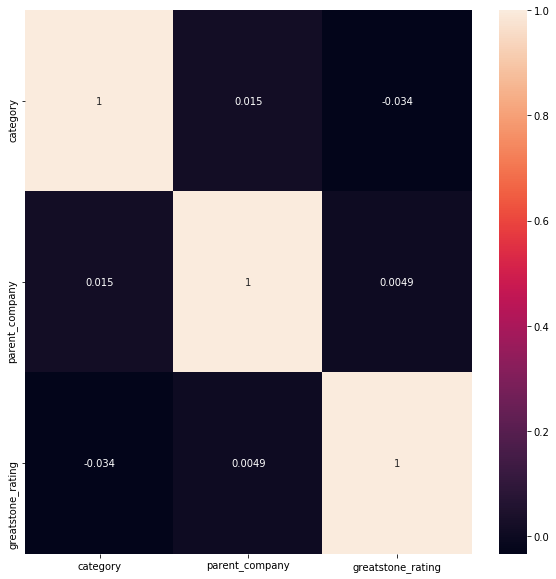

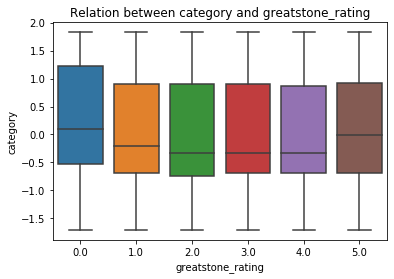

                         sum_sq       df          F    PR(>F)
greatstone_rating     23.430238      1.0  23.523397  0.000001
Residual           19918.802371  19998.0        NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.2309  0.001 -0.3394 -0.1224   True
   0.0    2.0  -0.2634  0.001 -0.3518  -0.175   True
   0.0    3.0  -0.2654  0.001 -0.3496 -0.1812   True
   0.0    4.0   -0.279  0.001 -0.3665 -0.1915   True
   0.0    5.0  -0.1741  0.001 -0.2782 -0.0699   True
   1.0    2.0  -0.0325    0.9 -0.1206  0.0556  False
   1.0    3.0  -0.0345  0.833 -0.1184  0.0495  False
   1.0    4.0  -0.0481 0.6013 -0.1353  0.0391  False
   1.0    5.0   0.0569 0.6088 -0.0471  0.1608  False
   2.0    3.0   -0.002    0.9 -0.0576  0.0537  False
   2.0    4.0  -0.0156    0.9  -0.076  0.0449  False
   2.0    5.0   0.0894 0.0256  0.0066  0.1721   True
   3.0    4.0  -0.0

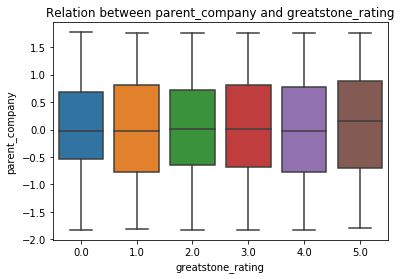

                         sum_sq       df         F    PR(>F)
greatstone_rating      0.492822      1.0  0.489522  0.484149
Residual           20132.809937  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0048    0.9 -0.1141 0.1044  False
   0.0    2.0   0.0221    0.9 -0.0669 0.1111  False
   0.0    3.0    0.001    0.9 -0.0838 0.0858  False
   0.0    4.0  -0.0162    0.9 -0.1043 0.0719  False
   0.0    5.0   0.0793 0.2601 -0.0257 0.1842  False
   1.0    2.0    0.027    0.9 -0.0618 0.1157  False
   1.0    3.0   0.0058    0.9 -0.0787 0.0904  False
   1.0    4.0  -0.0114    0.9 -0.0992 0.0764  False
   1.0    5.0   0.0841 0.1982 -0.0206 0.1888  False
   2.0    3.0  -0.0211  0.888 -0.0771 0.0349  False
   2.0    4.0  -0.0383 0.4698 -0.0992 0.0225  False
   2.0    5.0   0.0571 0.3709 -0.0262 0.1405  False
   3.0    4.0  -0.0172    0.9 -0.0718

In [110]:
handle_fundconfigdata = HandleData('fund_config.csv')
handle_data_references.append(handle_fundconfigdata)
handle_fundconfigdata.read_data()
handle_fundconfigdata.drop_columns(['fund_name'])
handle_fundconfigdata.handle_categorydata(['category', 'parent_company'])
handle_fundconfigdata.describe_data()
handle_fundconfigdata.handle_outliers()
handle_fundconfigdata.show_correlation(figsize = (10,10))
handle_fundconfigdata.handle_missingvalues()
handle_fundconfigdata.describe_data()
handle_fundconfigdata.show_pairwise()
if handle_fundconfigdata.check_correlation():
    print("Has correlation")
    print(handle_fundconfigdata.correlated_cols_list)
else:
    print('No correlation')

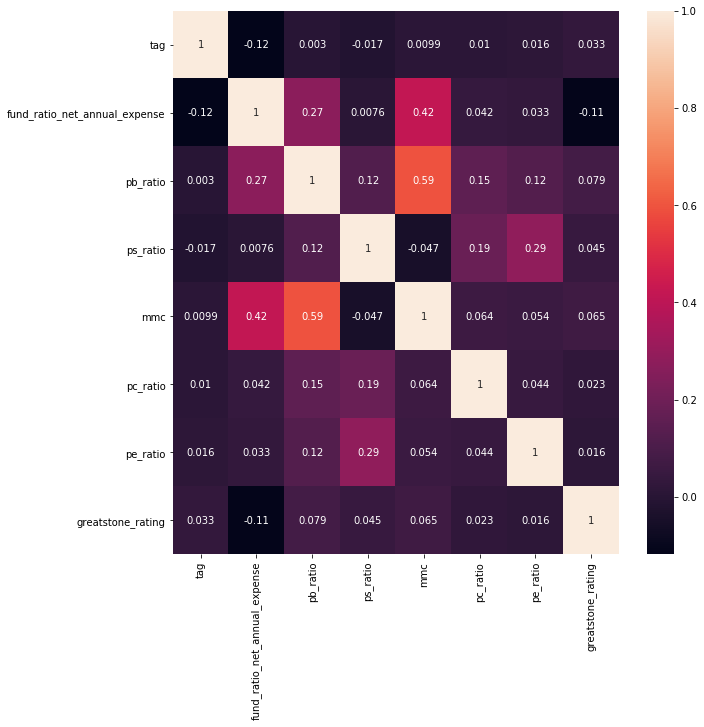

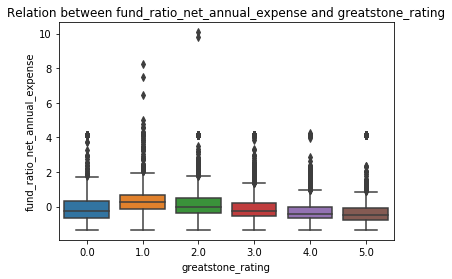

                         sum_sq       df           F        PR(>F)
greatstone_rating    251.608522      1.0  253.850463  8.407940e-57
Residual           19821.382897  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.4203  0.001  0.3124  0.5281   True
   0.0    2.0   0.1834  0.001  0.0956  0.2713   True
   0.0    3.0   0.0105    0.9 -0.0733  0.0942  False
   0.0    4.0  -0.0904 0.0363 -0.1773 -0.0034   True
   0.0    5.0  -0.1925  0.001 -0.2961  -0.089   True
   1.0    2.0  -0.2368  0.001 -0.3244 -0.1492   True
   1.0    3.0  -0.4098  0.001 -0.4933 -0.3264   True
   1.0    4.0  -0.5106  0.001 -0.5973 -0.4239   True
   1.0    5.0  -0.6128  0.001 -0.7162 -0.5095   True
   2.0    3.0   -0.173  0.001 -0.2283 -0.1177   True
   2.0    4.0  -0.2738  0.001 -0.3339 -0.2137   True
   2.0    5.0   -0.376  0.001 -0.4583 -0.2937   True
   3

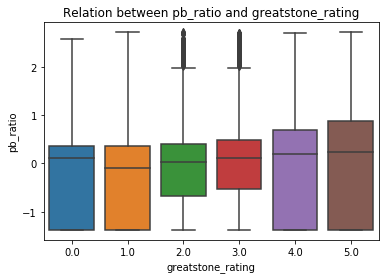

                         sum_sq       df           F        PR(>F)
greatstone_rating    123.838954      1.0  124.852374  6.677423e-29
Residual           19835.677338  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.1178 0.0239 -0.2262 -0.0095   True
   0.0    2.0   0.0189    0.9 -0.0694  0.1072  False
   0.0    3.0   0.1127 0.0019  0.0285  0.1968   True
   0.0    4.0   0.1578  0.001  0.0704  0.2452   True
   0.0    5.0   0.2308  0.001  0.1267  0.3349   True
   1.0    2.0   0.1368  0.001  0.0487  0.2248   True
   1.0    3.0   0.2305  0.001  0.1466  0.3144   True
   1.0    4.0   0.2756  0.001  0.1885  0.3627   True
   1.0    5.0   0.3486  0.001  0.2448  0.4525   True
   2.0    3.0   0.0937  0.001  0.0382  0.1493   True
   2.0    4.0   0.1388  0.001  0.0784  0.1992   True
   2.0    5.0   0.2119  0.001  0.1291  0.2946   True
   3

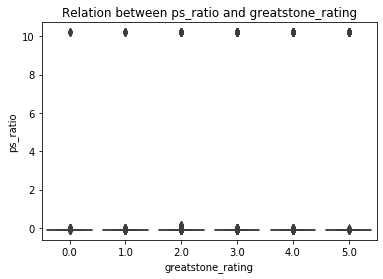

                         sum_sq       df          F        PR(>F)
greatstone_rating     37.570728      1.0  40.693612  1.819710e-10
Residual           18463.326191  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0221    0.9 -0.0825 0.1266  False
   0.0    2.0   0.0207    0.9 -0.0645 0.1059  False
   0.0    3.0   0.0541 0.4045 -0.0271 0.1353  False
   0.0    4.0   0.0784 0.0858 -0.0059 0.1628  False
   0.0    5.0   0.2154  0.001  0.1149 0.3158   True
   1.0    2.0  -0.0014    0.9 -0.0863 0.0836  False
   1.0    3.0    0.032 0.8572 -0.0489  0.113  False
   1.0    4.0   0.0564 0.3971 -0.0277 0.1405  False
   1.0    5.0   0.1933  0.001  0.0931 0.2936   True
   2.0    3.0   0.0334 0.4824 -0.0202  0.087  False
   2.0    4.0   0.0577 0.0538 -0.0005  0.116  False
   2.0    5.0   0.1947  0.001  0.1149 0.2745   True
   3.0    4.0   0.0243

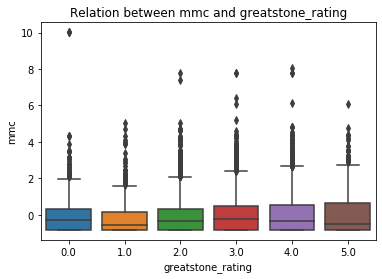

                         sum_sq       df          F        PR(>F)
greatstone_rating     84.493253      1.0  84.726316  3.755257e-20
Residual           19942.990059  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.1562  0.001 -0.2648 -0.0476   True
   0.0    2.0   0.0085    0.9   -0.08   0.097  False
   0.0    3.0   0.1072  0.004  0.0229  0.1915   True
   0.0    4.0   0.1598  0.001  0.0722  0.2474   True
   0.0    5.0   0.0919 0.1212 -0.0124  0.1962  False
   1.0    2.0   0.1647  0.001  0.0765  0.2529   True
   1.0    3.0   0.2633  0.001  0.1793  0.3474   True
   1.0    4.0    0.316  0.001  0.2287  0.4033   True
   1.0    5.0   0.2481  0.001   0.144  0.3521   True
   2.0    3.0   0.0987  0.001   0.043  0.1544   True
   2.0    4.0   0.1513  0.001  0.0908  0.2118   True
   2.0    5.0   0.0834 0.0476  0.0005  0.1663   True
   3.0 

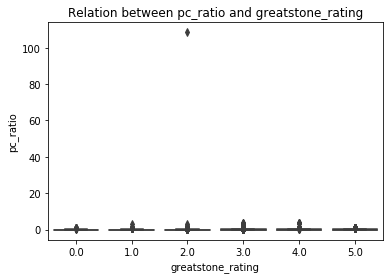

                         sum_sq       df          F    PR(>F)
greatstone_rating      6.652338      1.0  10.301932  0.001331
Residual           12913.446101  19998.0        NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0017    0.9 -0.0858 0.0892  False
   0.0    2.0   0.0528 0.2812 -0.0185 0.1241  False
   0.0    3.0     0.04  0.541  -0.028 0.1079  False
   0.0    4.0   0.0623   0.12 -0.0083 0.1328  False
   0.0    5.0   0.0799 0.0736 -0.0041 0.1639  False
   1.0    2.0   0.0511 0.3145   -0.02 0.1222  False
   1.0    3.0   0.0382 0.5795 -0.0295 0.1059  False
   1.0    4.0   0.0605 0.1381 -0.0098 0.1309  False
   1.0    5.0   0.0782 0.0844 -0.0057  0.162  False
   2.0    3.0  -0.0129    0.9 -0.0577  0.032  False
   2.0    4.0   0.0094    0.9 -0.0393 0.0582  False
   2.0    5.0   0.0271 0.8418 -0.0397 0.0938  False
   3.0    4.0   0.0223 0.6684 -0.0

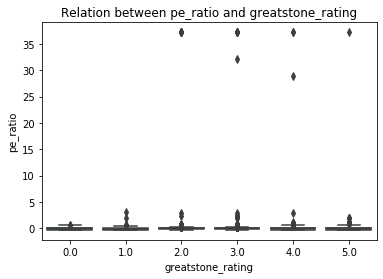

                         sum_sq       df         F    PR(>F)
greatstone_rating      5.861710      1.0  5.319778  0.021095
Residual           22035.219063  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0054    0.9 -0.1197 0.1088  False
   0.0    2.0     0.07 0.2653 -0.0231 0.1631  False
   0.0    3.0   0.0639 0.3126 -0.0248 0.1527  False
   0.0    4.0   0.0605 0.4231 -0.0317 0.1526  False
   0.0    5.0   0.0793 0.3091 -0.0305 0.1891  False
   1.0    2.0   0.0755 0.1872 -0.0174 0.1683  False
   1.0    3.0   0.0694 0.2217 -0.0191 0.1578  False
   1.0    4.0   0.0659 0.3172  -0.026 0.1578  False
   1.0    5.0   0.0848 0.2352 -0.0248 0.1943  False
   2.0    3.0  -0.0061    0.9 -0.0647 0.0525  False
   2.0    4.0  -0.0095    0.9 -0.0732 0.0541  False
   2.0    5.0   0.0093    0.9 -0.0779 0.0965  False
   3.0    4.0  -0.0035    0.9 -0.0605

In [112]:
handle_fundratiosdata = HandleData('fund_ratios.csv')
handle_data_references.append(handle_fundratiosdata)
handle_fundratiosdata.read_data()
handle_fundratiosdata.describe_data()
handle_fundratiosdata.handle_outliers()
handle_fundratiosdata.show_correlation(figsize = (10,10))
handle_fundratiosdata.handle_missingvalues()
handle_fundratiosdata.describe_data()
handle_fundratiosdata.show_pairwise()
if handle_fundratiosdata.check_correlation():
    print("Has correlation")
    print(handle_fundratiosdata.correlated_cols_list)
else:
    print('No correlation')

In [113]:
# handle_fundratiosdata.correlated_cols_list.append('fund_ratio_net_annual_expense')
# handle_fundratiosdata.correlated_cols_list.append('pb_ratio')
handle_fundratiosdata.correlated_cols_list

['fund_ratio_net_annual_expense']

In [114]:
handle_fundratiosdata.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 9 columns):
fund_id                          25000 non-null object
tag                              25000 non-null float64
fund_ratio_net_annual_expense    25000 non-null float64
pb_ratio                         25000 non-null float64
ps_ratio                         25000 non-null float64
mmc                              25000 non-null float64
pc_ratio                         25000 non-null float64
pe_ratio                         25000 non-null float64
greatstone_rating                20000 non-null float64
dtypes: float64(8), object(1)
memory usage: 1.7+ MB


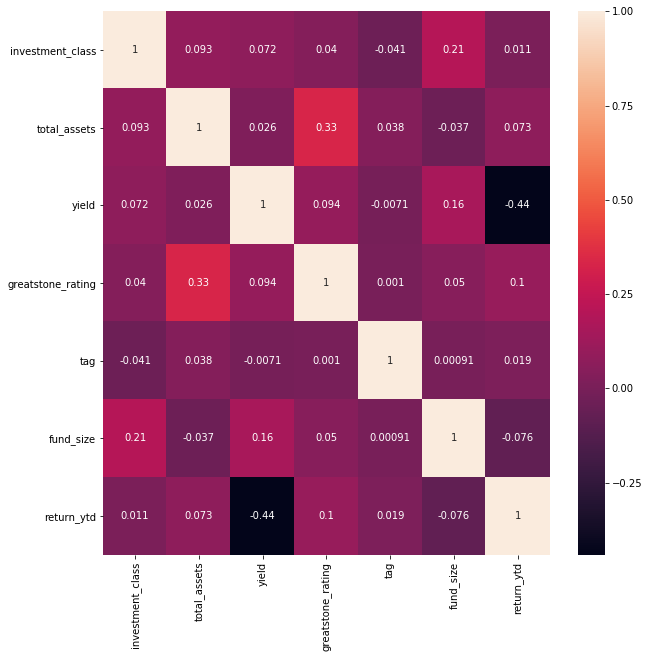

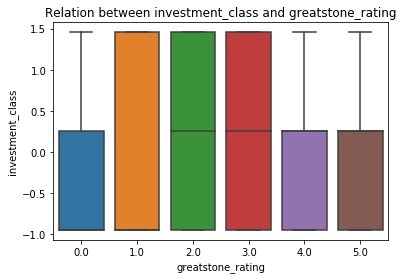

                         sum_sq       df          F        PR(>F)
greatstone_rating     32.522743      1.0  32.542177  1.182812e-08
Residual           19986.057010  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.2606  0.001   0.152 0.3692   True
   0.0    2.0   0.3236  0.001   0.235 0.4121   True
   0.0    3.0   0.2824  0.001   0.198 0.3667   True
   0.0    4.0   0.2756  0.001  0.1879 0.3632   True
   0.0    5.0   0.3004  0.001   0.196 0.4047   True
   1.0    2.0   0.0629 0.3234 -0.0253 0.1512  False
   1.0    3.0   0.0218    0.9 -0.0623 0.1058  False
   1.0    4.0   0.0149    0.9 -0.0724 0.1023  False
   1.0    5.0   0.0398 0.8802 -0.0643 0.1439  False
   2.0    3.0  -0.0412 0.2836 -0.0969 0.0145  False
   2.0    4.0   -0.048 0.2106 -0.1085 0.0125  False
   2.0    5.0  -0.0232    0.9 -0.1061 0.0597  False
   3.0    4.0  -0.0068

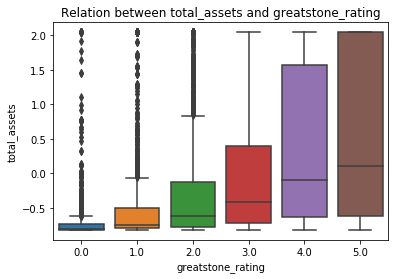

                         sum_sq       df            F  PR(>F)
greatstone_rating   2187.683646      1.0  2465.801274     0.0
Residual           17742.426374  19998.0          NaN     NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   0.0    1.0   0.1956 0.001 0.0931  0.298   True
   0.0    2.0   0.4152 0.001 0.3317 0.4987   True
   0.0    3.0   0.7154 0.001 0.6358  0.795   True
   0.0    4.0   1.0204 0.001 0.9377 1.1031   True
   0.0    5.0   1.1875 0.001 1.0891 1.2859   True
   1.0    2.0   0.2196 0.001 0.1364 0.3029   True
   1.0    3.0   0.5198 0.001 0.4405 0.5991   True
   1.0    4.0   0.8248 0.001 0.7424 0.9072   True
   1.0    5.0   0.9919 0.001 0.8937 1.0902   True
   2.0    3.0   0.3002 0.001 0.2477 0.3528   True
   2.0    4.0   0.6052 0.001 0.5481 0.6623   True
   2.0    5.0   0.7723 0.001 0.6941 0.8505   True
   3.0    4.0    0.305 0.001 0.2538 0.3562   True
   3.0    5.

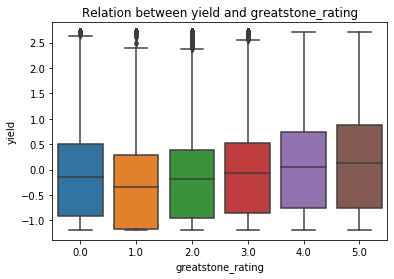

                         sum_sq       df           F        PR(>F)
greatstone_rating    174.890727      1.0  176.630646  3.903204e-40
Residual           19801.007646  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.1634  0.001 -0.2716 -0.0552   True
   0.0    2.0  -0.0581 0.4183 -0.1462  0.0301  False
   0.0    3.0   0.0409 0.7081 -0.0431  0.1249  False
   0.0    4.0   0.1699  0.001  0.0826  0.2571   True
   0.0    5.0   0.2317  0.001  0.1278  0.3356   True
   1.0    2.0   0.1053 0.0084  0.0174  0.1932   True
   1.0    3.0   0.2043  0.001  0.1205   0.288   True
   1.0    4.0   0.3332  0.001  0.2463  0.4202   True
   1.0    5.0   0.3951  0.001  0.2914  0.4988   True
   2.0    3.0   0.0989  0.001  0.0435  0.1544   True
   2.0    4.0   0.2279  0.001  0.1676  0.2882   True
   2.0    5.0   0.2898  0.001  0.2072  0.3723   True
   3

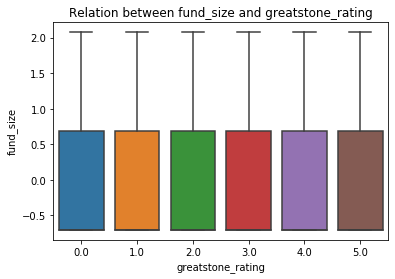

                         sum_sq       df          F        PR(>F)
greatstone_rating     50.543997      1.0  50.652338  1.139957e-12
Residual           19955.225994  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1595  0.001  0.0508 0.2683   True
   0.0    2.0   0.1712  0.001  0.0826 0.2598   True
   0.0    3.0    0.177  0.001  0.0926 0.2615   True
   0.0    4.0   0.2146  0.001  0.1269 0.3023   True
   0.0    5.0   0.2713  0.001  0.1669 0.3758   True
   1.0    2.0   0.0117    0.9 -0.0766    0.1  False
   1.0    3.0   0.0175    0.9 -0.0666 0.1017  False
   1.0    4.0   0.0551 0.4693 -0.0323 0.1425  False
   1.0    5.0   0.1118 0.0271  0.0076  0.216   True
   2.0    3.0   0.0058    0.9 -0.0499 0.0616  False
   2.0    4.0   0.0434 0.3185 -0.0172  0.104  False
   2.0    5.0   0.1001 0.0077  0.0171 0.1831   True
   3.0    4.0   0.0376

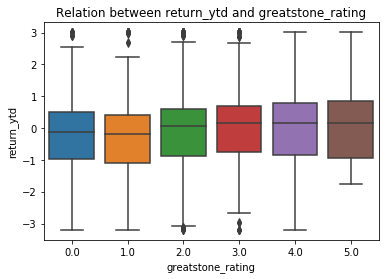

                         sum_sq       df           F        PR(>F)
greatstone_rating    217.021028      1.0  220.518072  1.281871e-49
Residual           19680.865558  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0248    0.9 -0.0831 0.1328  False
   0.0    2.0   0.2108  0.001  0.1228 0.2987   True
   0.0    3.0   0.3038  0.001    0.22 0.3876   True
   0.0    4.0   0.3458  0.001  0.2588 0.4329   True
   0.0    5.0   0.3669  0.001  0.2632 0.4706   True
   1.0    2.0   0.1859  0.001  0.0982 0.2736   True
   1.0    3.0    0.279  0.001  0.1954 0.3625   True
   1.0    4.0    0.321  0.001  0.2342 0.4078   True
   1.0    5.0   0.3421  0.001  0.2386 0.4456   True
   2.0    3.0    0.093  0.001  0.0377 0.1484   True
   2.0    4.0    0.135  0.001  0.0749 0.1952   True
   2.0    5.0   0.1562  0.001  0.0738 0.2385   True
   3.0    4.0    0.

In [115]:
handle_fundspecs = HandleData('fund_specs.csv')
handle_data_references.append(handle_fundspecs)
handle_fundspecs.read_data()
handle_fundspecs.drop_columns(['currency','inception_date'])
handle_fundspecs.handle_categorydata(['fund_size', 'investment_class'])
handle_fundspecs.describe_data()
handle_fundspecs.handle_outliers()
handle_fundspecs.show_correlation(figsize = (10,10))
handle_fundspecs.handle_missingvalues()
handle_fundspecs.describe_data()
handle_fundspecs.show_pairwise()
if handle_fundspecs.check_correlation():
    print("Has correlation")
    print(handle_fundspecs.correlated_cols_list)
else:
    print('No correlation')

In [116]:
# handle_fundspecs.correlated_cols_list.append('total_assets')
handle_fundspecs.correlated_cols_list

['total_assets', 'return_ytd']

In [117]:
handle_fundspecs.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 7 columns):
investment_class     25000 non-null int32
total_assets         25000 non-null float64
yield                25000 non-null float64
greatstone_rating    20000 non-null float64
tag                  25000 non-null int64
fund_size            25000 non-null int32
return_ytd           25000 non-null float64
dtypes: float64(4), int32(2), int64(1)
memory usage: 1.1 MB


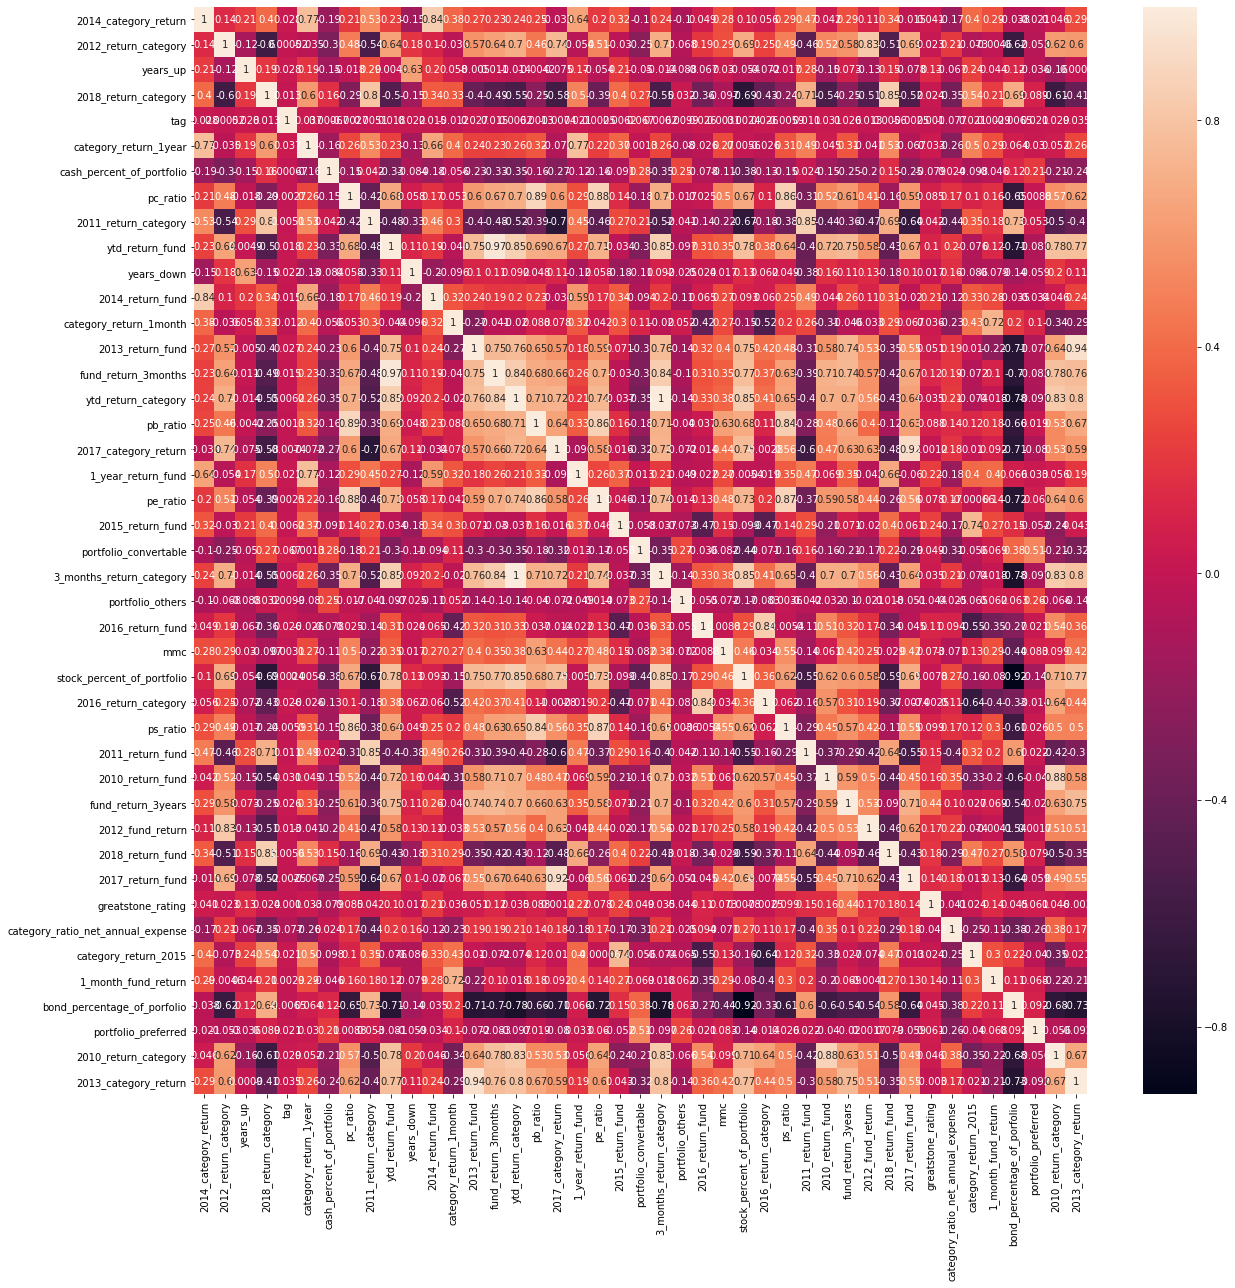

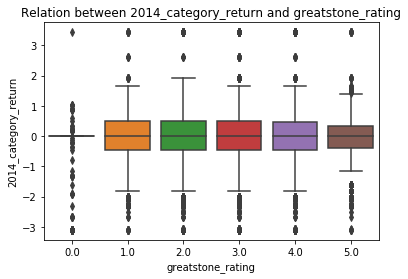

                         sum_sq       df          F   PR(>F)
greatstone_rating     18.283054      1.0  18.236208  0.00002
Residual           20049.371488  19998.0        NaN      NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1832  0.001  0.0743 0.2922   True
   0.0    2.0   0.1607  0.001   0.072 0.2495   True
   0.0    3.0   0.1985  0.001  0.1139 0.2831   True
   0.0    4.0   0.1974  0.001  0.1096 0.2853   True
   0.0    5.0   0.1519  0.001  0.0472 0.2565   True
   1.0    2.0  -0.0225    0.9  -0.111  0.066  False
   1.0    3.0   0.0153    0.9 -0.0691 0.0996  False
   1.0    4.0   0.0142    0.9 -0.0734 0.1018  False
   1.0    5.0  -0.0313    0.9 -0.1357 0.0731  False
   2.0    3.0   0.0377  0.388 -0.0181 0.0936  False
   2.0    4.0   0.0367 0.5141  -0.024 0.0974  False
   2.0    5.0  -0.0088    0.9  -0.092 0.0743  False
   3.0    4.0   -0.001    0.9 -0.0555

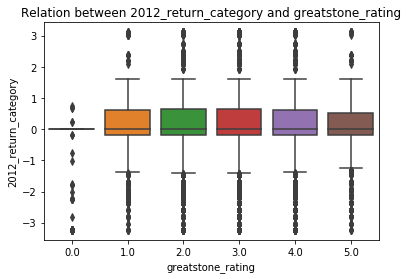

                         sum_sq       df         F    PR(>F)
greatstone_rating      4.203133      1.0  4.204701  0.040325
Residual           19990.544167  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1429 0.0025  0.0341 0.2516   True
   0.0    2.0   0.1936  0.001   0.105 0.2822   True
   0.0    3.0   0.1894  0.001  0.1049 0.2738   True
   0.0    4.0   0.1527  0.001   0.065 0.2404   True
   0.0    5.0   0.1126 0.0259  0.0082 0.2171   True
   1.0    2.0   0.0507 0.5639 -0.0376 0.1391  False
   1.0    3.0   0.0465 0.5996 -0.0377 0.1306  False
   1.0    4.0   0.0098    0.9 -0.0776 0.0973  False
   1.0    5.0  -0.0303    0.9 -0.1345  0.074  False
   2.0    3.0  -0.0042    0.9   -0.06 0.0515  False
   2.0    4.0  -0.0409 0.3892 -0.1015 0.0197  False
   2.0    5.0   -0.081 0.0607  -0.164  0.002  False
   3.0    4.0  -0.0367  0.389  -0.091

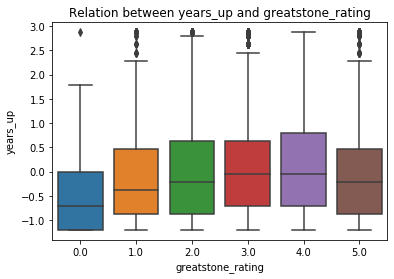

                         sum_sq       df           F        PR(>F)
greatstone_rating    295.649073      1.0  296.237363  6.494185e-66
Residual           19958.286530  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.4288  0.001  0.3208  0.5368   True
   0.0    2.0    0.605  0.001   0.517   0.693   True
   0.0    3.0   0.6476  0.001  0.5637  0.7314   True
   0.0    4.0   0.6915  0.001  0.6044  0.7786   True
   0.0    5.0   0.5498  0.001  0.4461  0.6535   True
   1.0    2.0   0.1762  0.001  0.0885  0.2639   True
   1.0    3.0   0.2188  0.001  0.1352  0.3024   True
   1.0    4.0   0.2627  0.001  0.1758  0.3495   True
   1.0    5.0    0.121 0.0112  0.0175  0.2245   True
   2.0    3.0   0.0426 0.2417 -0.0128   0.098  False
   2.0    4.0   0.0865  0.001  0.0263  0.1466   True
   2.0    5.0  -0.0552 0.3985 -0.1376  0.0272  False
   3

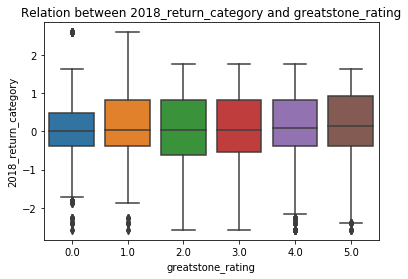

                         sum_sq       df          F   PR(>F)
greatstone_rating     11.154961      1.0  11.154803  0.00084
Residual           19998.283045  19998.0        NaN      NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0445 0.8358 -0.0643 0.1533  False
   0.0    2.0  -0.0436 0.6997 -0.1323 0.0451  False
   0.0    3.0  -0.0213    0.9 -0.1058 0.0632  False
   0.0    4.0   0.0514 0.5445 -0.0363 0.1392  False
   0.0    5.0   0.0878  0.158 -0.0167 0.1923  False
   1.0    2.0  -0.0881 0.0514 -0.1765 0.0003  False
   1.0    3.0  -0.0658 0.2253   -0.15 0.0184  False
   1.0    4.0   0.0069    0.9 -0.0806 0.0944  False
   1.0    5.0   0.0433 0.8252  -0.061 0.1476  False
   2.0    3.0   0.0223 0.8515 -0.0335 0.0781  False
   2.0    4.0    0.095  0.001  0.0344 0.1556   True
   2.0    5.0   0.1314  0.001  0.0484 0.2145   True
   3.0    4.0   0.0727 0.0019  0.0184

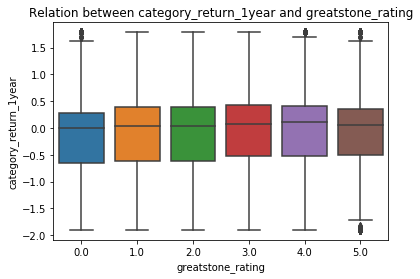

                         sum_sq       df          F    PR(>F)
greatstone_rating     21.831330      1.0  21.915863  0.000003
Residual           19920.864032  19998.0        NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1132 0.0354  0.0045 0.2218   True
   0.0    2.0    0.124  0.001  0.0355 0.2125   True
   0.0    3.0   0.1654  0.001  0.0811 0.2498   True
   0.0    4.0    0.178  0.001  0.0904 0.2656   True
   0.0    5.0   0.1245 0.0089  0.0201 0.2288   True
   1.0    2.0   0.0108    0.9 -0.0775  0.099  False
   1.0    3.0   0.0523 0.4845 -0.0318 0.1363  False
   1.0    4.0   0.0649 0.2788 -0.0225 0.1522  False
   1.0    5.0   0.0113    0.9 -0.0928 0.1154  False
   2.0    3.0   0.0415 0.2756 -0.0142 0.0972  False
   2.0    4.0   0.0541 0.1113 -0.0065 0.1146  False
   2.0    5.0   0.0005    0.9 -0.0824 0.0834  False
   3.0    4.0   0.0126    0.9 -0.0

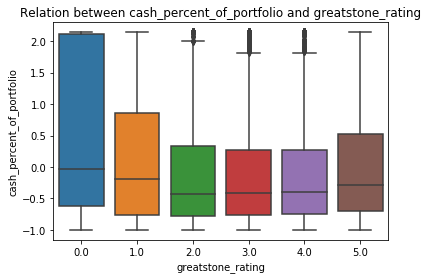

                         sum_sq       df           F        PR(>F)
greatstone_rating    123.200278      1.0  124.292652  8.837983e-29
Residual           19822.243193  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.2161  0.001  -0.324 -0.1081   True
   0.0    2.0  -0.4299  0.001 -0.5179  -0.342   True
   0.0    3.0  -0.4367  0.001 -0.5205 -0.3529   True
   0.0    4.0  -0.4556  0.001 -0.5426 -0.3685   True
   0.0    5.0  -0.3312  0.001 -0.4349 -0.2276   True
   1.0    2.0  -0.2139  0.001 -0.3016 -0.1262   True
   1.0    3.0  -0.2206  0.001 -0.3041 -0.1371   True
   1.0    4.0  -0.2395  0.001 -0.3263 -0.1527   True
   1.0    5.0  -0.1152 0.0189 -0.2186 -0.0117   True
   2.0    3.0  -0.0067    0.9 -0.0621  0.0486  False
   2.0    4.0  -0.0256 0.8076 -0.0858  0.0345  False
   2.0    5.0   0.0987 0.0084  0.0163  0.1811   True
   3

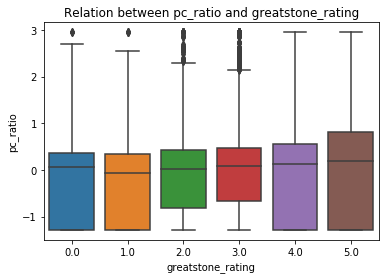

                         sum_sq       df           F        PR(>F)
greatstone_rating    142.549215      1.0  144.172781  4.233319e-33
Residual           19772.797510  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0499   0.75 -0.1582 0.0583  False
   0.0    2.0   0.0721 0.1822 -0.0161 0.1603  False
   0.0    3.0   0.1374  0.001  0.0533 0.2214   True
   0.0    4.0    0.208  0.001  0.1207 0.2953   True
   0.0    5.0   0.2909  0.001  0.1869 0.3949   True
   1.0    2.0    0.122 0.0011  0.0341 0.2099   True
   1.0    3.0   0.1873  0.001  0.1035  0.271   True
   1.0    4.0   0.2579  0.001  0.1709 0.3449   True
   1.0    5.0   0.3408  0.001  0.2371 0.4446   True
   2.0    3.0   0.0653 0.0104  0.0098 0.1208   True
   2.0    4.0   0.1359  0.001  0.0756 0.1962   True
   2.0    5.0   0.2188  0.001  0.1362 0.3014   True
   3.0    4.0   0.0

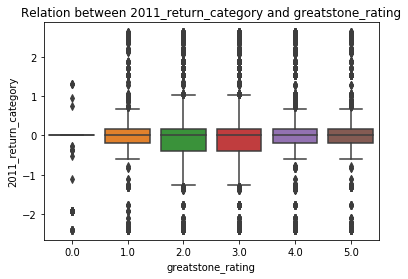

                         sum_sq       df          F    PR(>F)
greatstone_rating     14.962659      1.0  14.945746  0.000111
Residual           20020.629309  19998.0        NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1218 0.0181  0.0128 0.2307   True
   0.0    2.0   0.0656 0.2846 -0.0232 0.1543  False
   0.0    3.0   0.0694 0.1778 -0.0151  0.154  False
   0.0    4.0    0.116 0.0023  0.0282 0.2038   True
   0.0    5.0   0.1544  0.001  0.0498  0.259   True
   1.0    2.0  -0.0562 0.4606 -0.1447 0.0323  False
   1.0    3.0  -0.0523 0.4867 -0.1366  0.032  False
   1.0    4.0  -0.0058    0.9 -0.0933 0.0818  False
   1.0    5.0   0.0326    0.9 -0.0717  0.137  False
   2.0    3.0   0.0039    0.9  -0.052 0.0597  False
   2.0    4.0   0.0504 0.1674 -0.0102 0.1111  False
   2.0    5.0   0.0889 0.0281  0.0057  0.172   True
   3.0    4.0   0.0466 0.1428 -0.0

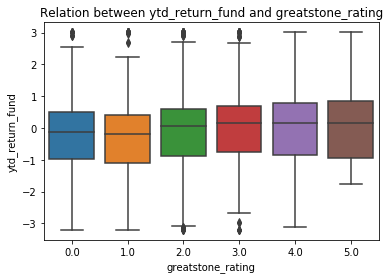

                         sum_sq       df           F        PR(>F)
greatstone_rating    214.425056      1.0  217.992479  4.495458e-49
Residual           19670.734877  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0    0.024    0.9 -0.0839 0.1319  False
   0.0    2.0   0.2121  0.001  0.1241    0.3   True
   0.0    3.0   0.3024  0.001  0.2186 0.3862   True
   0.0    4.0   0.3436  0.001  0.2566 0.4307   True
   0.0    5.0   0.3669  0.001  0.2632 0.4705   True
   1.0    2.0   0.1881  0.001  0.1004 0.2757   True
   1.0    3.0   0.2783  0.001  0.1948 0.3619   True
   1.0    4.0   0.3196  0.001  0.2329 0.4064   True
   1.0    5.0   0.3429  0.001  0.2394 0.4463   True
   2.0    3.0   0.0903  0.001  0.0349 0.1456   True
   2.0    4.0   0.1316  0.001  0.0714 0.1917   True
   2.0    5.0   0.1548  0.001  0.0724 0.2372   True
   3.0    4.0   0.0

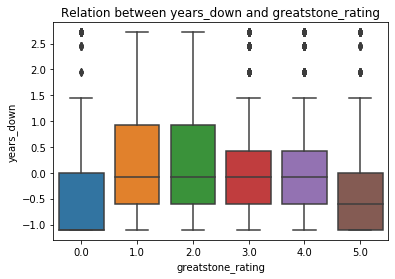

                         sum_sq       df        F    PR(>F)
greatstone_rating      5.209093      1.0  5.18236  0.022828
Residual           20101.160169  19998.0      NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0    1.0   0.8168 0.001  0.7099  0.9237   True
   0.0    2.0   0.8007 0.001  0.7137  0.8878   True
   0.0    3.0   0.6855 0.001  0.6025  0.7685   True
   0.0    4.0   0.6069 0.001  0.5207  0.6931   True
   0.0    5.0   0.3779 0.001  0.2753  0.4806   True
   1.0    2.0   -0.016   0.9 -0.1029  0.0708  False
   1.0    3.0  -0.1313 0.001  -0.214 -0.0486   True
   1.0    4.0  -0.2099 0.001 -0.2958  -0.124   True
   1.0    5.0  -0.4388 0.001 -0.5413 -0.3364   True
   2.0    3.0  -0.1153 0.001 -0.1701 -0.0605   True
   2.0    4.0  -0.1939 0.001 -0.2534 -0.1343   True
   2.0    5.0  -0.4228 0.001 -0.5044 -0.3412   True
   3.0    4.0  -0.0786 0.001  -0.132 -0.

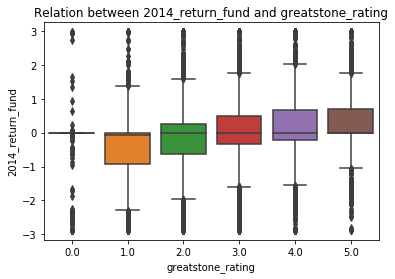

                         sum_sq       df           F        PR(>F)
greatstone_rating    433.018211      1.0  442.213241  4.016139e-97
Residual           19582.177506  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.2427  0.001 -0.3502 -0.1352   True
   0.0    2.0  -0.0074    0.9  -0.095  0.0801  False
   0.0    3.0   0.1842  0.001  0.1008  0.2677   True
   0.0    4.0   0.2864  0.001  0.1997   0.373   True
   0.0    5.0   0.3936  0.001  0.2904  0.4968   True
   1.0    2.0   0.2353  0.001   0.148  0.3226   True
   1.0    3.0   0.4269  0.001  0.3438  0.5101   True
   1.0    4.0   0.5291  0.001  0.4427  0.6155   True
   1.0    5.0   0.6363  0.001  0.5333  0.7393   True
   2.0    3.0   0.1917  0.001  0.1365  0.2468   True
   2.0    4.0   0.2938  0.001  0.2339  0.3537   True
   2.0    5.0    0.401  0.001   0.319  0.4831   True
   3

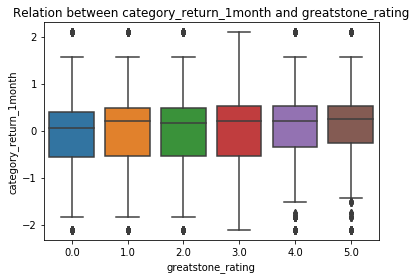

                         sum_sq       df          F        PR(>F)
greatstone_rating     25.351558      1.0  25.463352  4.548177e-07
Residual           19910.200533  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1062 0.0598 -0.0024 0.2148  False
   0.0    2.0   0.0611 0.3618 -0.0274 0.1496  False
   0.0    3.0   0.0922 0.0226  0.0079 0.1766   True
   0.0    4.0   0.1376  0.001  0.0499 0.2252   True
   0.0    5.0   0.1588  0.001  0.0545 0.2631   True
   1.0    2.0  -0.0451 0.6683 -0.1333 0.0432  False
   1.0    3.0   -0.014    0.9  -0.098 0.0701  False
   1.0    4.0   0.0314    0.9  -0.056 0.1187  False
   1.0    5.0   0.0526 0.6771 -0.0515 0.1567  False
   2.0    3.0   0.0311 0.5899 -0.0246 0.0868  False
   2.0    4.0   0.0764 0.0043  0.0159  0.137   True
   2.0    5.0   0.0977 0.0102  0.0148 0.1806   True
   3.0    4.0   0.0453

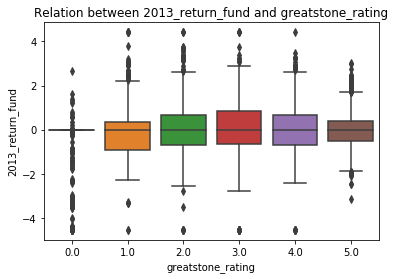

                         sum_sq       df         F    PR(>F)
greatstone_rating     23.533885      1.0  23.64292  0.000001
Residual           19905.775096  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0687 0.4645 -0.0398 0.1772  False
   0.0    2.0   0.1651  0.001  0.0767 0.2535   True
   0.0    3.0   0.2036  0.001  0.1193 0.2879   True
   0.0    4.0   0.1751  0.001  0.0876 0.2627   True
   0.0    5.0   0.1358 0.0028  0.0315   0.24   True
   1.0    2.0   0.0964 0.0226  0.0082 0.1846   True
   1.0    3.0   0.1349  0.001  0.0509 0.2189   True
   1.0    4.0   0.1064 0.0068  0.0192 0.1937   True
   1.0    5.0   0.0671 0.4435  -0.037 0.1711  False
   2.0    3.0   0.0385  0.359 -0.0171 0.0942  False
   2.0    4.0     0.01    0.9 -0.0504 0.0705  False
   2.0    5.0  -0.0293    0.9 -0.1122 0.0535  False
   3.0    4.0  -0.0285 0.6441 -0.0827

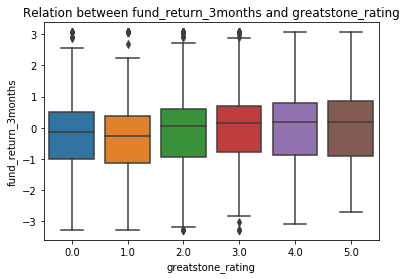

                         sum_sq       df           F        PR(>F)
greatstone_rating    265.935979      1.0  270.707734  1.985594e-60
Residual           19645.495994  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0021    0.9 -0.1058 0.1099  False
   0.0    2.0   0.2097  0.001  0.1219 0.2976   True
   0.0    3.0   0.3196  0.001  0.2359 0.4034   True
   0.0    4.0   0.3643  0.001  0.2774 0.4513   True
   0.0    5.0   0.3973  0.001  0.2937 0.5009   True
   1.0    2.0   0.2077  0.001  0.1201 0.2953   True
   1.0    3.0   0.3176  0.001  0.2341  0.401   True
   1.0    4.0   0.3623  0.001  0.2756  0.449   True
   1.0    5.0   0.3953  0.001  0.2919 0.4986   True
   2.0    3.0   0.1099  0.001  0.0546 0.1652   True
   2.0    4.0   0.1546  0.001  0.0945 0.2147   True
   2.0    5.0   0.1876  0.001  0.1053 0.2699   True
   3.0    4.0   0.0

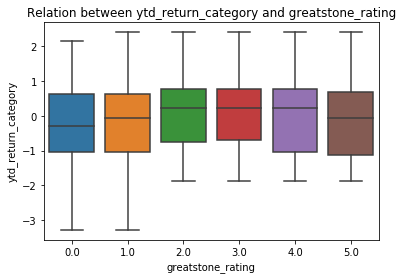

                         sum_sq       df          F        PR(>F)
greatstone_rating     24.735341      1.0  24.740906  6.612105e-07
Residual           19993.501622  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.1553  0.001  0.0468  0.2638   True
   0.0    2.0   0.3039  0.001  0.2155  0.3923   True
   0.0    3.0    0.331  0.001  0.2468  0.4153   True
   0.0    4.0   0.2671  0.001  0.1796  0.3546   True
   0.0    5.0   0.1652  0.001   0.061  0.2694   True
   1.0    2.0   0.1486  0.001  0.0604  0.2367   True
   1.0    3.0   0.1757  0.001  0.0917  0.2597   True
   1.0    4.0   0.1118 0.0036  0.0245   0.199   True
   1.0    5.0   0.0099    0.9 -0.0941  0.1139  False
   2.0    3.0   0.0271 0.7061 -0.0285  0.0828  False
   2.0    4.0  -0.0368 0.5065 -0.0973  0.0236  False
   2.0    5.0  -0.1387  0.001 -0.2215 -0.0559   True
   3.0 

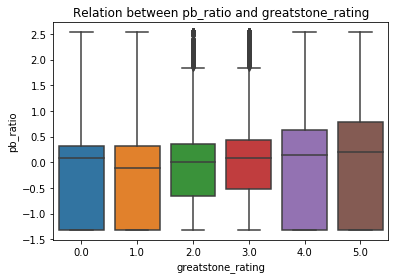

                         sum_sq       df           F        PR(>F)
greatstone_rating    152.894069      1.0  154.742139  2.155509e-35
Residual           19759.165931  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.1197   0.02 -0.2279 -0.0116   True
   0.0    2.0   0.0171    0.9 -0.0711  0.1052  False
   0.0    3.0   0.1215  0.001  0.0375  0.2055   True
   0.0    4.0   0.1795  0.001  0.0923  0.2667   True
   0.0    5.0   0.2553  0.001  0.1514  0.3592   True
   1.0    2.0   0.1368  0.001  0.0489  0.2247   True
   1.0    3.0   0.2412  0.001  0.1575  0.3249   True
   1.0    4.0   0.2992  0.001  0.2122  0.3862   True
   1.0    5.0    0.375  0.001  0.2713  0.4787   True
   2.0    3.0   0.1044  0.001   0.049  0.1599   True
   2.0    4.0   0.1624  0.001  0.1021  0.2227   True
   2.0    5.0   0.2382  0.001  0.1557  0.3208   True
   3

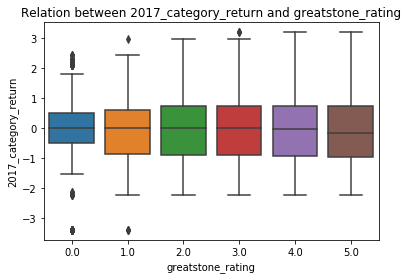

                        sum_sq       df         F   PR(>F)
greatstone_rating      0.01936      1.0  0.019357  0.88935
Residual           20001.74645  19998.0       NaN      NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0491 0.7658 -0.0597  0.158  False
   0.0    2.0   0.1098 0.0056  0.0211 0.1985   True
   0.0    3.0    0.102 0.0076  0.0175 0.1866   True
   0.0    4.0   0.0522 0.5305 -0.0356   0.14  False
   0.0    5.0   0.0424  0.841 -0.0621  0.147  False
   1.0    2.0   0.0607  0.369 -0.0277 0.1491  False
   1.0    3.0   0.0529 0.4731 -0.0313 0.1371  False
   1.0    4.0    0.003    0.9 -0.0845 0.0905  False
   1.0    5.0  -0.0067    0.9  -0.111 0.0976  False
   2.0    3.0  -0.0078    0.9 -0.0636  0.048  False
   2.0    4.0  -0.0576 0.0738 -0.1183  0.003  False
   2.0    5.0  -0.0674  0.189 -0.1505 0.0157  False
   3.0    4.0  -0.0499 0.0936 -0.1042 0.004

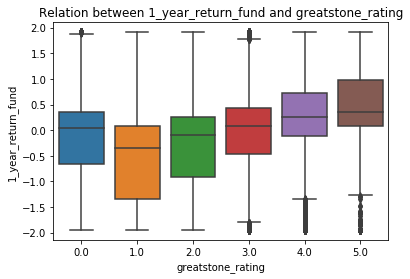

                         sum_sq       df            F         PR(>F)
greatstone_rating    971.615088      1.0  1023.329951  4.929068e-219
Residual           18987.383797  19998.0          NaN            NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.4003  0.001 -0.5054 -0.2951   True
   0.0    2.0  -0.1496  0.001 -0.2353 -0.0639   True
   0.0    3.0   0.1093 0.0019  0.0277   0.191   True
   0.0    4.0   0.3619  0.001  0.2771  0.4467   True
   0.0    5.0   0.5769  0.001  0.4759  0.6779   True
   1.0    2.0   0.2507  0.001  0.1653  0.3361   True
   1.0    3.0   0.5096  0.001  0.4282   0.591   True
   1.0    4.0   0.7622  0.001  0.6776  0.8467   True
   1.0    5.0   0.9772  0.001  0.8764   1.078   True
   2.0    3.0   0.2589  0.001   0.205  0.3128   True
   2.0    4.0   0.5115  0.001  0.4529  0.5701   True
   2.0    5.0   0.7265  0.001  0.6462  0.8068   Tru

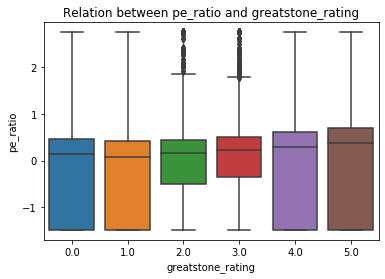

                         sum_sq       df           F        PR(>F)
greatstone_rating    120.331600      1.0  121.549818  3.491833e-28
Residual           19797.572412  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   -0.047  0.794 -0.1553 0.0613  False
   0.0    2.0   0.0876  0.053 -0.0006 0.1759  False
   0.0    3.0   0.1621  0.001   0.078 0.2462   True
   0.0    4.0   0.2005  0.001  0.1131 0.2878   True
   0.0    5.0   0.2626  0.001  0.1586 0.3667   True
   1.0    2.0   0.1347  0.001  0.0467 0.2226   True
   1.0    3.0   0.2092  0.001  0.1254  0.293   True
   1.0    4.0   0.2475  0.001  0.1605 0.3346   True
   1.0    5.0   0.3097  0.001  0.2059 0.4135   True
   2.0    3.0   0.0745 0.0018   0.019 0.1301   True
   2.0    4.0   0.1129  0.001  0.0525 0.1732   True
   2.0    5.0    0.175  0.001  0.0923 0.2577   True
   3.0    4.0   0.0

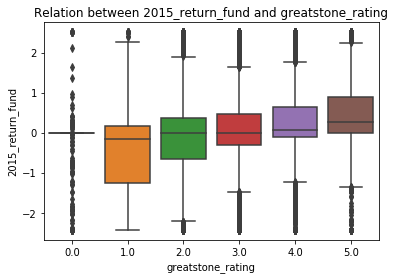

                         sum_sq       df           F         PR(>F)
greatstone_rating    638.378726      1.0  660.483408  2.476282e-143
Residual           19328.718340  19998.0         NaN            NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.4335  0.001 -0.5398 -0.3272   True
   0.0    2.0  -0.1156  0.002 -0.2022  -0.029   True
   0.0    3.0   0.0625 0.2573   -0.02   0.145  False
   0.0    4.0   0.2326  0.001  0.1469  0.3183   True
   0.0    5.0   0.4953  0.001  0.3932  0.5974   True
   1.0    2.0   0.3179  0.001  0.2315  0.4042   True
   1.0    3.0    0.496  0.001  0.4137  0.5782   True
   1.0    4.0   0.6661  0.001  0.5807  0.7515   True
   1.0    5.0   0.9288  0.001   0.827  1.0307   True
   2.0    3.0   0.1781  0.001  0.1236  0.2326   True
   2.0    4.0   0.3482  0.001   0.289  0.4075   True
   2.0    5.0   0.6109  0.001  0.5298  0.6921   True
 

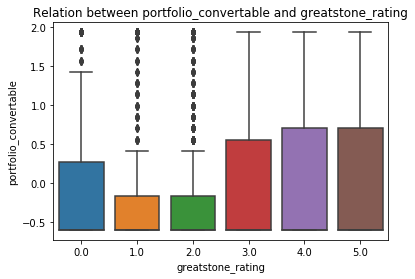

                         sum_sq       df          F        PR(>F)
greatstone_rating     46.848214      1.0  46.959434  7.458037e-12
Residual           19950.636309  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0699 0.4466 -0.1786 0.0388  False
   0.0    2.0  -0.0385 0.7942  -0.127 0.0501  False
   0.0    3.0    0.059 0.3466 -0.0254 0.1434  False
   0.0    4.0   0.0936 0.0284  0.0059 0.1813   True
   0.0    5.0   0.1016 0.0617 -0.0028 0.2061  False
   1.0    2.0   0.0314    0.9 -0.0569 0.1197  False
   1.0    3.0   0.1289  0.001  0.0448  0.213   True
   1.0    4.0   0.1635  0.001  0.0761 0.2509   True
   1.0    5.0   0.1715  0.001  0.0674 0.2757   True
   2.0    3.0   0.0975  0.001  0.0417 0.1532   True
   2.0    4.0   0.1321  0.001  0.0715 0.1926   True
   2.0    5.0   0.1401  0.001  0.0571 0.2231   True
   3.0    4.0   0.0346

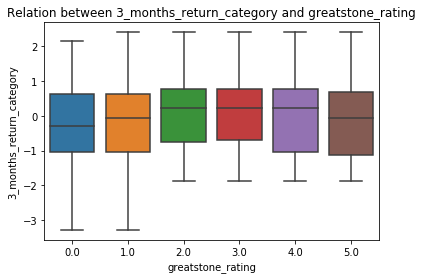

                         sum_sq       df          F        PR(>F)
greatstone_rating     24.735341      1.0  24.740906  6.612105e-07
Residual           19993.501622  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.1553  0.001  0.0468  0.2638   True
   0.0    2.0   0.3039  0.001  0.2155  0.3923   True
   0.0    3.0    0.331  0.001  0.2468  0.4153   True
   0.0    4.0   0.2671  0.001  0.1796  0.3546   True
   0.0    5.0   0.1652  0.001   0.061  0.2694   True
   1.0    2.0   0.1486  0.001  0.0604  0.2367   True
   1.0    3.0   0.1757  0.001  0.0917  0.2597   True
   1.0    4.0   0.1118 0.0036  0.0245   0.199   True
   1.0    5.0   0.0099    0.9 -0.0941  0.1139  False
   2.0    3.0   0.0271 0.7061 -0.0285  0.0828  False
   2.0    4.0  -0.0368 0.5065 -0.0973  0.0236  False
   2.0    5.0  -0.1387  0.001 -0.2215 -0.0559   True
   3.0 

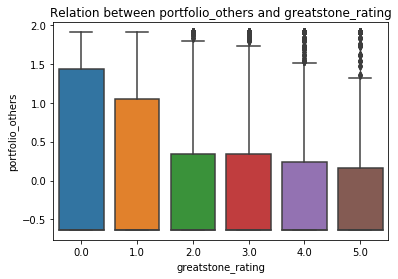

                         sum_sq       df          F        PR(>F)
greatstone_rating     39.046957      1.0  39.183656  3.936028e-10
Residual           19928.233661  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.0297    0.9 -0.1384   0.079  False
   0.0    2.0  -0.1281  0.001 -0.2167 -0.0396   True
   0.0    3.0  -0.1439  0.001 -0.2283 -0.0596   True
   0.0    4.0  -0.1618  0.001 -0.2494 -0.0741   True
   0.0    5.0   -0.181  0.001 -0.2853 -0.0766   True
   1.0    2.0  -0.0984 0.0186 -0.1867 -0.0101   True
   1.0    3.0  -0.1142 0.0015 -0.1983 -0.0301   True
   1.0    4.0   -0.132  0.001 -0.2194 -0.0447   True
   1.0    5.0  -0.1512  0.001 -0.2554 -0.0471   True
   2.0    3.0  -0.0158    0.9 -0.0715  0.0399  False
   2.0    4.0  -0.0336 0.5954 -0.0942  0.0269  False
   2.0    5.0  -0.0528 0.4577 -0.1358  0.0301  False
   3.0 

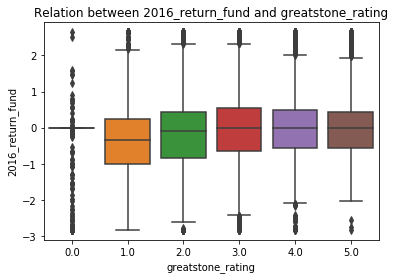

                         sum_sq       df           F        PR(>F)
greatstone_rating    144.274005      1.0  144.561195  3.486345e-33
Residual           19958.271397  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   -0.116 0.0282 -0.2246 -0.0074   True
   0.0    2.0   0.0731 0.1732 -0.0154  0.1616  False
   0.0    3.0   0.2224  0.001  0.1381  0.3068   True
   0.0    4.0   0.2097  0.001  0.1221  0.2973   True
   0.0    5.0   0.2192  0.001  0.1149  0.3235   True
   1.0    2.0   0.1891  0.001  0.1009  0.2773   True
   1.0    3.0   0.3385  0.001  0.2544  0.4225   True
   1.0    4.0   0.3257  0.001  0.2384   0.413   True
   1.0    5.0   0.3352  0.001  0.2311  0.4393   True
   2.0    3.0   0.1494  0.001  0.0937  0.2051   True
   2.0    4.0   0.1366  0.001  0.0761  0.1971   True
   2.0    5.0   0.1461  0.001  0.0632   0.229   True
   3

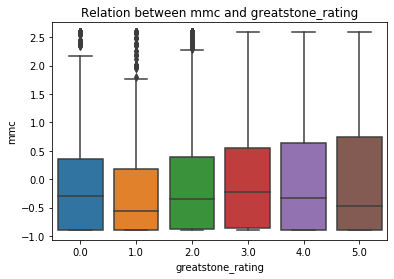

                         sum_sq       df           F        PR(>F)
greatstone_rating    105.283845      1.0  105.242619  1.243729e-24
Residual           20005.833643  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.1521  0.001 -0.2609 -0.0434   True
   0.0    2.0   0.0249    0.9 -0.0637  0.1135  False
   0.0    3.0   0.1298  0.001  0.0453  0.2142   True
   0.0    4.0   0.1786  0.001  0.0909  0.2663   True
   0.0    5.0   0.1307 0.0049  0.0262  0.2351   True
   1.0    2.0    0.177  0.001  0.0887  0.2654   True
   1.0    3.0   0.2819  0.001  0.1977  0.3661   True
   1.0    4.0   0.3307  0.001  0.2433  0.4182   True
   1.0    5.0   0.2828  0.001  0.1785   0.387   True
   2.0    3.0   0.1049  0.001  0.0491  0.1606   True
   2.0    4.0   0.1537  0.001  0.0931  0.2143   True
   2.0    5.0   0.1057 0.0039  0.0227  0.1888   True
   3

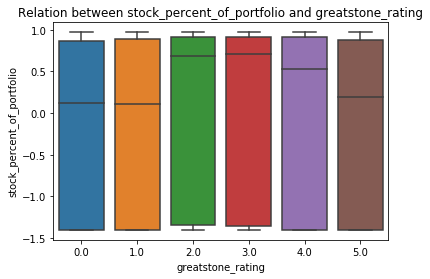

                         sum_sq       df        F    PR(>F)
greatstone_rating      1.197668      1.0  1.19609  0.274118
Residual           20024.378477  19998.0      NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.0063    0.9 -0.1023   0.115  False
   0.0    2.0    0.181  0.001  0.0924  0.2695   True
   0.0    3.0   0.1875  0.001  0.1031  0.2719   True
   0.0    4.0   0.1092 0.0052  0.0215  0.1968   True
   0.0    5.0   0.0194    0.9  -0.085  0.1238  False
   1.0    2.0   0.1746  0.001  0.0863  0.2629   True
   1.0    3.0   0.1811  0.001   0.097  0.2653   True
   1.0    4.0   0.1028 0.0104  0.0154  0.1902   True
   1.0    5.0    0.013    0.9 -0.0911  0.1172  False
   2.0    3.0   0.0065    0.9 -0.0492  0.0623  False
   2.0    4.0  -0.0718 0.0095 -0.1323 -0.0112   True
   2.0    5.0  -0.1616  0.001 -0.2445 -0.0786   True
   3.0    4.0  -0.0783  0

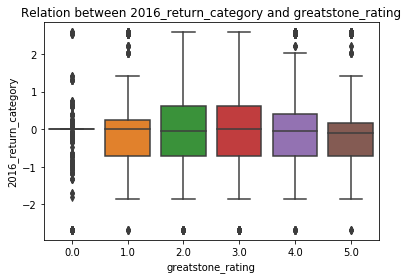

                         sum_sq       df         F    PR(>F)
greatstone_rating      0.096381      1.0  0.095898  0.756812
Residual           20098.816084  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.0513 0.7341 -0.0577  0.1603  False
   0.0    2.0    0.088 0.0539 -0.0008  0.1768  False
   0.0    3.0    0.142  0.001  0.0574  0.2266   True
   0.0    4.0    0.072 0.1796 -0.0159  0.1599  False
   0.0    5.0  -0.0437  0.822 -0.1484   0.061  False
   1.0    2.0   0.0367 0.8273 -0.0519  0.1252  False
   1.0    3.0   0.0907 0.0266  0.0063   0.175   True
   1.0    4.0   0.0207    0.9 -0.0669  0.1084  False
   1.0    5.0   -0.095 0.0992 -0.1995  0.0095  False
   2.0    3.0    0.054 0.0653 -0.0019  0.1099  False
   2.0    4.0  -0.0159    0.9 -0.0767  0.0448  False
   2.0    5.0  -0.1317  0.001 -0.2149 -0.0485   True
   3.0    4.0    -0.07

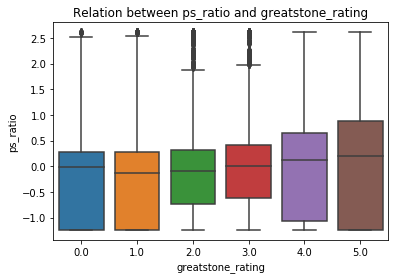

                         sum_sq       df          F        PR(>F)
greatstone_rating    192.948025      1.0  195.77272  2.826278e-44
Residual           19709.460035  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0181    0.9   -0.09 0.1262  False
   0.0    2.0   0.0826 0.0808 -0.0054 0.1707  False
   0.0    3.0   0.1697  0.001  0.0858 0.2536   True
   0.0    4.0   0.2618  0.001  0.1746  0.349   True
   0.0    5.0   0.3588  0.001   0.255 0.4626   True
   1.0    2.0   0.0645 0.2902 -0.0233 0.1523  False
   1.0    3.0   0.1516  0.001  0.0679 0.2352   True
   1.0    4.0   0.2437  0.001  0.1568 0.3306   True
   1.0    5.0   0.3407  0.001  0.2371 0.4443   True
   2.0    3.0   0.0871  0.001  0.0316 0.1425   True
   2.0    4.0   0.1792  0.001   0.119 0.2394   True
   2.0    5.0   0.2762  0.001  0.1937 0.3587   True
   3.0    4.0   0.0921

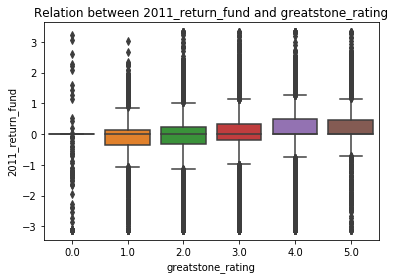

                         sum_sq       df          F        PR(>F)
greatstone_rating    173.536411      1.0  175.44827  7.036556e-40
Residual           19780.081900  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0745 0.3655 -0.1827 0.0337  False
   0.0    2.0   0.0012    0.9  -0.087 0.0893  False
   0.0    3.0   0.0757 0.1056 -0.0083 0.1597  False
   0.0    4.0   0.2085  0.001  0.1213 0.2958   True
   0.0    5.0   0.2832  0.001  0.1793 0.3872   True
   1.0    2.0   0.0756 0.1384 -0.0123 0.1635  False
   1.0    3.0   0.1501  0.001  0.0664 0.2339   True
   1.0    4.0    0.283  0.001   0.196   0.37   True
   1.0    5.0   0.3577  0.001   0.254 0.4614   True
   2.0    3.0   0.0745 0.0018   0.019   0.13   True
   2.0    4.0   0.2074  0.001  0.1471 0.2677   True
   2.0    5.0   0.2821  0.001  0.1995 0.3647   True
   3.0    4.0   0.1329

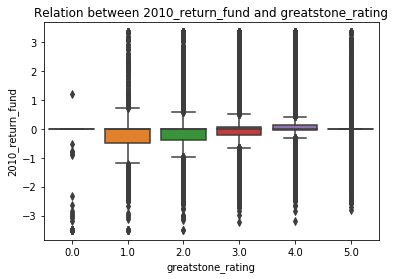

                         sum_sq       df           F        PR(>F)
greatstone_rating    174.809967      1.0  175.367121  7.327009e-40
Residual           19934.464963  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0536 0.6967 -0.1622  0.055  False
   0.0    2.0   0.1084 0.0064  0.0199 0.1969   True
   0.0    3.0   0.2061  0.001  0.1218 0.2904   True
   0.0    4.0    0.302  0.001  0.2145 0.3896   True
   0.0    5.0   0.2264  0.001  0.1221 0.3307   True
   1.0    2.0    0.162  0.001  0.0738 0.2502   True
   1.0    3.0   0.2597  0.001  0.1756 0.3437   True
   1.0    4.0   0.3556  0.001  0.2683 0.4429   True
   1.0    5.0     0.28  0.001  0.1759 0.3841   True
   2.0    3.0   0.0977  0.001   0.042 0.1534   True
   2.0    4.0   0.1936  0.001  0.1331 0.2541   True
   2.0    5.0    0.118  0.001  0.0351 0.2009   True
   3.0    4.0    0.

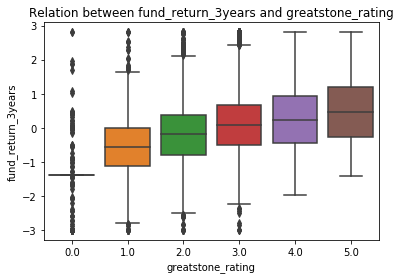

                         sum_sq       df            F  PR(>F)
greatstone_rating   3789.300756      1.0  4696.883772     0.0
Residual           16133.768726  19998.0          NaN     NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   0.0    1.0   0.8606 0.001 0.7642  0.957   True
   0.0    2.0    1.236 0.001 1.1575 1.3146   True
   0.0    3.0   1.5326 0.001 1.4577 1.6074   True
   0.0    4.0    1.714 0.001 1.6363 1.7918   True
   0.0    5.0   1.9458 0.001 1.8532 2.0383   True
   1.0    2.0   0.3755 0.001 0.2972 0.4538   True
   1.0    3.0    0.672 0.001 0.5974 0.7466   True
   1.0    4.0   0.8534 0.001 0.7759  0.931   True
   1.0    5.0   1.0852 0.001 0.9928 1.1776   True
   2.0    3.0   0.2965 0.001 0.2471  0.346   True
   2.0    4.0    0.478 0.001 0.4243 0.5317   True
   2.0    5.0   0.7097 0.001 0.6361 0.7833   True
   3.0    4.0   0.1814 0.001 0.1333 0.2296   True
   3.0    5.

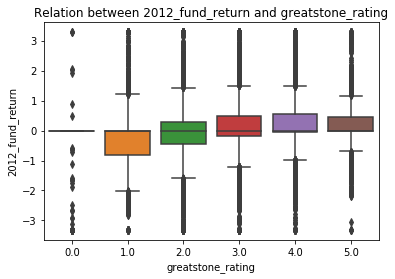

                         sum_sq       df           F        PR(>F)
greatstone_rating    238.561002      1.0  242.677316  2.141580e-54
Residual           19658.792165  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0473  0.788 -0.1552 0.0606  False
   0.0    2.0   0.0708  0.196 -0.0171 0.1587  False
   0.0    3.0   0.1935  0.001  0.1097 0.2773   True
   0.0    4.0   0.2919  0.001  0.2049 0.3789   True
   0.0    5.0   0.3265  0.001  0.2229 0.4302   True
   1.0    2.0   0.1181 0.0017  0.0304 0.2057   True
   1.0    3.0   0.2408  0.001  0.1573 0.3243   True
   1.0    4.0   0.3391  0.001  0.2524 0.4259   True
   1.0    5.0   0.3738  0.001  0.2704 0.4772   True
   2.0    3.0   0.1227  0.001  0.0674 0.1781   True
   2.0    4.0   0.2211  0.001   0.161 0.2812   True
   2.0    5.0   0.2557  0.001  0.1734 0.3381   True
   3.0    4.0   0.0

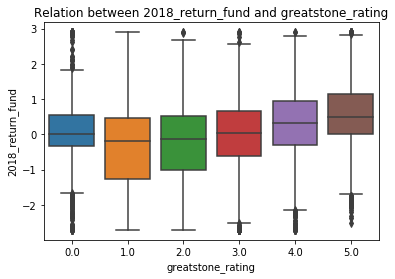

                         sum_sq       df           F         PR(>F)
greatstone_rating    633.714359      1.0  655.317448  3.030334e-142
Residual           19338.749162  19998.0         NaN            NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.4897  0.001 -0.5953  -0.384   True
   0.0    2.0   -0.324  0.001 -0.4101 -0.2379   True
   0.0    3.0  -0.1061 0.0031 -0.1881  -0.024   True
   0.0    4.0   0.1484  0.001  0.0632  0.2336   True
   0.0    5.0     0.42  0.001  0.3185  0.5215   True
   1.0    2.0   0.1657  0.001  0.0798  0.2515   True
   1.0    3.0   0.3836  0.001  0.3018  0.4654   True
   1.0    4.0   0.6381  0.001  0.5531   0.723   True
   1.0    5.0   0.9097  0.001  0.8084   1.011   True
   2.0    3.0    0.218  0.001  0.1638  0.2721   True
   2.0    4.0   0.4724  0.001  0.4135  0.5313   True
   2.0    5.0    0.744  0.001  0.6634  0.8247   True
 

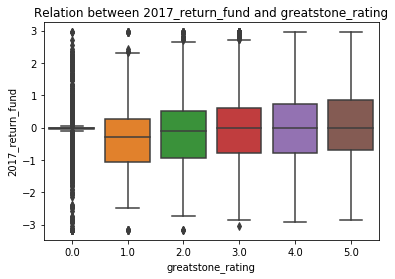

                         sum_sq       df          F        PR(>F)
greatstone_rating    310.795799      1.0  316.44383  2.998650e-70
Residual           19641.066737  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0    1.0  -0.1534 0.001 -0.2611 -0.0456   True
   0.0    2.0   0.0188   0.9  -0.069  0.1066  False
   0.0    3.0   0.1608 0.001  0.0772  0.2445   True
   0.0    4.0   0.2543 0.001  0.1674  0.3413   True
   0.0    5.0   0.3771 0.001  0.2735  0.4806   True
   1.0    2.0   0.1722 0.001  0.0846  0.2597   True
   1.0    3.0   0.3142 0.001  0.2308  0.3976   True
   1.0    4.0   0.4077 0.001   0.321  0.4943   True
   1.0    5.0   0.5304 0.001  0.4271  0.6337   True
   2.0    3.0    0.142 0.001  0.0868  0.1973   True
   2.0    4.0   0.2355 0.001  0.1755  0.2956   True
   2.0    5.0   0.3583 0.001   0.276  0.4405   True
   3.0    4.0   0.0935

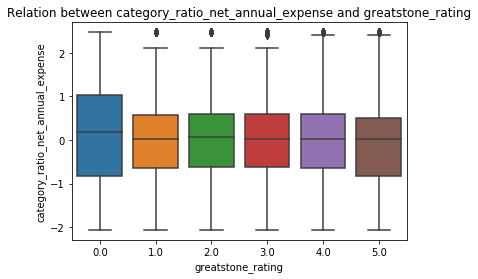

                         sum_sq       df          F        PR(>F)
greatstone_rating     33.266346      1.0  33.173903  8.551013e-09
Residual           20053.726613  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.1138 0.0348 -0.2228 -0.0048   True
   0.0    2.0  -0.0777 0.1257 -0.1665  0.0111  False
   0.0    3.0  -0.1052 0.0053 -0.1898 -0.0205   True
   0.0    4.0  -0.1133 0.0033 -0.2012 -0.0254   True
   0.0    5.0  -0.2514  0.001 -0.3561 -0.1468   True
   1.0    2.0   0.0361 0.8376 -0.0524  0.1246  False
   1.0    3.0   0.0086    0.9 -0.0757   0.093  False
   1.0    4.0   0.0004    0.9 -0.0872  0.0881  False
   1.0    5.0  -0.1376 0.0024 -0.2421 -0.0332   True
   2.0    3.0  -0.0275 0.6995 -0.0834  0.0284  False
   2.0    4.0  -0.0357 0.5423 -0.0964  0.0251  False
   2.0    5.0  -0.1738  0.001 -0.2569 -0.0906   True
   3.0 

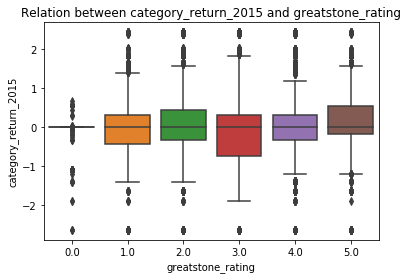

                         sum_sq       df         F    PR(>F)
greatstone_rating      6.646337      1.0  6.631305  0.010027
Residual           20043.330950  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0    0.024    0.9 -0.0849  0.133  False
   0.0    2.0   0.0646  0.302 -0.0242 0.1533  False
   0.0    3.0   0.0132    0.9 -0.0714 0.0978  False
   0.0    4.0   0.0432 0.6993 -0.0446 0.1311  False
   0.0    5.0    0.145 0.0011  0.0403 0.2496   True
   1.0    2.0   0.0405 0.7556  -0.048  0.129  False
   1.0    3.0  -0.0109    0.9 -0.0952 0.0735  False
   1.0    4.0   0.0192    0.9 -0.0684 0.1068  False
   1.0    5.0   0.1209 0.0124  0.0165 0.2254   True
   2.0    3.0  -0.0514 0.0921 -0.1072 0.0045  False
   2.0    4.0  -0.0213    0.9  -0.082 0.0394  False
   2.0    5.0   0.0804 0.0649 -0.0027 0.1636  False
   3.0    4.0     0.03 0.6002 -0.0244

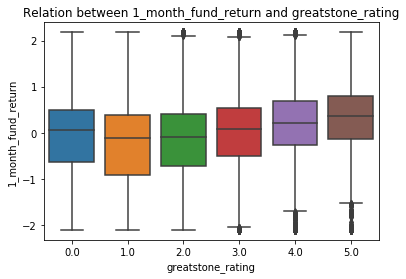

                         sum_sq       df           F        PR(>F)
greatstone_rating    372.498018      1.0  379.863659  7.986591e-84
Residual           19610.234299  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   -0.142 0.0023 -0.2494 -0.0345   True
   0.0    2.0  -0.1052 0.0081 -0.1928 -0.0177   True
   0.0    3.0    0.054 0.4381 -0.0294  0.1375  False
   0.0    4.0   0.2376  0.001  0.1509  0.3242   True
   0.0    5.0   0.4044  0.001  0.3012  0.5076   True
   1.0    2.0   0.0368 0.8159 -0.0505   0.124  False
   1.0    3.0    0.196  0.001  0.1128  0.2791   True
   1.0    4.0   0.3795  0.001  0.2932  0.4659   True
   1.0    5.0   0.5463  0.001  0.4433  0.6493   True
   2.0    3.0   0.1592  0.001  0.1041  0.2143   True
   2.0    4.0   0.3428  0.001  0.2829  0.4027   True
   2.0    5.0   0.5096  0.001  0.4276  0.5916   True
   3

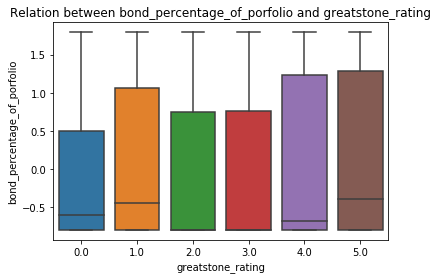

                         sum_sq       df          F        PR(>F)
greatstone_rating     39.903209      1.0  39.928768  2.689557e-10
Residual           19985.198845  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.1774  0.001  0.0686  0.2861   True
   0.0    2.0   0.0662 0.2726 -0.0224  0.1548  False
   0.0    3.0   0.0792 0.0806 -0.0052  0.1637  False
   0.0    4.0   0.1664  0.001  0.0787  0.2541   True
   0.0    5.0   0.2411  0.001  0.1367  0.3456   True
   1.0    2.0  -0.1112 0.0045 -0.1995 -0.0229   True
   1.0    3.0  -0.0981 0.0115 -0.1823  -0.014   True
   1.0    4.0   -0.011    0.9 -0.0984  0.0764  False
   1.0    5.0   0.0637 0.5023 -0.0405   0.168  False
   2.0    3.0   0.0131    0.9 -0.0427  0.0688  False
   2.0    4.0   0.1002  0.001  0.0396  0.1608   True
   2.0    5.0   0.1749  0.001  0.0919  0.2579   True
   3.0 

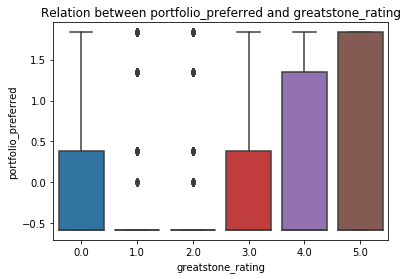

                         sum_sq       df          F        PR(>F)
greatstone_rating     72.555625      1.0  73.307936  1.188254e-17
Residual           19792.773584  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.1277   0.01 -0.2359 -0.0195   True
   0.0    2.0  -0.0876 0.0528 -0.1758  0.0006  False
   0.0    3.0   0.0026    0.9 -0.0814  0.0867  False
   0.0    4.0   0.0736 0.1547 -0.0137  0.1609  False
   0.0    5.0   0.1442 0.0011  0.0402  0.2481   True
   1.0    2.0   0.0401 0.7578 -0.0478   0.128  False
   1.0    3.0   0.1304  0.001  0.0466  0.2141   True
   1.0    4.0   0.2013  0.001  0.1143  0.2883   True
   1.0    5.0   0.2719  0.001  0.1682  0.3756   True
   2.0    3.0   0.0902  0.001  0.0347  0.1457   True
   2.0    4.0   0.1612  0.001  0.1009  0.2215   True
   2.0    5.0   0.2318  0.001  0.1492  0.3144   True
   3.0 

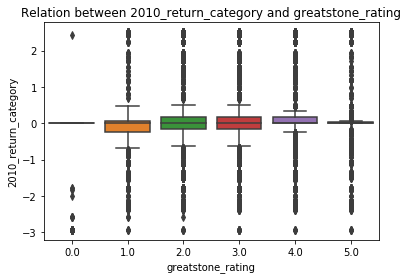

                         sum_sq       df          F    PR(>F)
greatstone_rating     15.251675      1.0  15.209037  0.000097
Residual           20054.064557  19998.0        NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.0215    0.9 -0.0874  0.1304  False
   0.0    2.0   0.1521  0.001  0.0634  0.2409   True
   0.0    3.0   0.1821  0.001  0.0976  0.2667   True
   0.0    4.0   0.1716  0.001  0.0838  0.2594   True
   0.0    5.0   0.0522 0.6869 -0.0523  0.1568  False
   1.0    2.0   0.1306  0.001  0.0422  0.2191   True
   1.0    3.0   0.1606  0.001  0.0763  0.2449   True
   1.0    4.0   0.1501  0.001  0.0625  0.2376   True
   1.0    5.0   0.0307    0.9 -0.0736  0.1351  False
   2.0    3.0     0.03 0.6254 -0.0259  0.0858  False
   2.0    4.0   0.0194    0.9 -0.0412  0.0801  False
   2.0    5.0  -0.0999 0.0081  -0.183 -0.0168   True
   3.0    4.0  -0.0

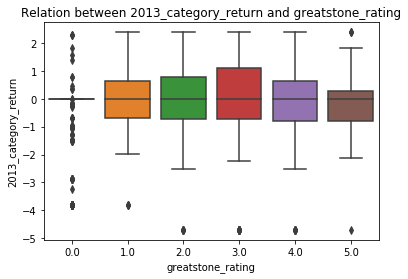

                         sum_sq       df         F    PR(>F)
greatstone_rating      0.125843      1.0  0.126373  0.722226
Residual           19914.052859  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.1577  0.001  0.0492  0.2661   True
   0.0    2.0   0.1964  0.001  0.1081  0.2848   True
   0.0    3.0   0.1915  0.001  0.1073  0.2757   True
   0.0    4.0   0.1318  0.001  0.0443  0.2192   True
   0.0    5.0   0.0339    0.9 -0.0703   0.138  False
   1.0    2.0   0.0387 0.7853 -0.0494  0.1268  False
   1.0    3.0   0.0338 0.8461 -0.0501  0.1177  False
   1.0    4.0  -0.0259    0.9 -0.1131  0.0613  False
   1.0    5.0  -0.1238  0.009 -0.2278 -0.0199   True
   2.0    3.0  -0.0049    0.9 -0.0605  0.0507  False
   2.0    4.0  -0.0647 0.0279 -0.1251 -0.0042   True
   2.0    5.0  -0.1626  0.001 -0.2453 -0.0798   True
   3.0    4.0  -0.0597

In [118]:
handle_otherspecs = HandleData('other_specs.csv')
handle_data_references.append(handle_otherspecs)
handle_otherspecs.read_data()
# handle_fundspecs.drop_columns(['fund_name'])
# handle_fundspecs.handle_categorydata(['currency', 'fund_size'])
handle_otherspecs.describe_data()
handle_otherspecs.handle_outliers()
handle_otherspecs.show_correlation(figsize = (20,20))
handle_otherspecs.handle_missingvalues()
handle_otherspecs.describe_data()
handle_otherspecs.show_pairwise()
if handle_otherspecs.check_correlation():
    print("Has correlation")
    print(handle_otherspecs.correlated_cols_list)
else:
    print('No correlation')

In [119]:
# handle_otherspecs.correlated_cols_list.append('pc_ratio')
# handle_otherspecs.correlated_cols_list.append('years_down')
# handle_otherspecs.correlated_cols_list.append('2014_return_fund')
# handle_otherspecs.correlated_cols_list.append('pb_ratio')
# handle_otherspecs.correlated_cols_list.append('1_year_return_fund')
# handle_otherspecs.correlated_cols_list.append('2015_return_fund')
# handle_otherspecs.correlated_cols_list.append('ps_ratio')
# handle_otherspecs.correlated_cols_list.append('2011_return_fund')
# handle_otherspecs.correlated_cols_list.append('fund_return_3years')
# handle_otherspecs.correlated_cols_list.append('2012_fund_return')
# handle_otherspecs.correlated_cols_list.append('2018_return_fund')
# handle_otherspecs.correlated_cols_list.append('2017_return_fund')
# handle_otherspecs.correlated_cols_list.append('1_month_fund_return')
# handle_otherspecs.correlated_cols_list.append('2010_return_category')
handle_otherspecs.correlated_cols_list

['years_up',
 'ytd_return_fund',
 '2014_return_fund',
 'fund_return_3months',
 '1_year_return_fund',
 '2015_return_fund',
 '2016_return_fund',
 '2011_return_fund',
 '2010_return_fund',
 'fund_return_3years',
 '2012_fund_return',
 '2018_return_fund',
 '2017_return_fund',
 '1_month_fund_return',
 'years_down',
 '2012_return_category',
 '2018_return_category',
 'pc_ratio',
 '2013_return_fund',
 'ytd_return_category',
 'pb_ratio',
 '2017_category_return',
 'pe_ratio',
 '3_months_return_category',
 'stock_percent_of_portfolio',
 'ps_ratio',
 'bond_percentage_of_porfolio',
 '2010_return_category',
 '2013_category_return',
 '2014_category_return',
 'category_return_1year',
 '2012_return_category',
 'pc_ratio',
 '2013_return_fund',
 'ytd_return_category',
 'pb_ratio',
 '2017_category_return',
 'pe_ratio',
 '3_months_return_category',
 'stock_percent_of_portfolio',
 'ps_ratio',
 'bond_percentage_of_porfolio',
 '2010_return_category',
 '2013_category_return',
 '2014_category_return',
 'category_

In [120]:
handle_otherspecs.df.columns

Index(['2014_category_return', '2012_return_category', 'years_up',
       '2018_return_category', 'tag', 'category_return_1year',
       'cash_percent_of_portfolio', 'pc_ratio', '2011_return_category',
       'ytd_return_fund', 'years_down', '2014_return_fund',
       'category_return_1month', '2013_return_fund', 'fund_return_3months',
       'ytd_return_category', 'pb_ratio', '2017_category_return',
       '1_year_return_fund', 'pe_ratio', '2015_return_fund',
       'portfolio_convertable', '3_months_return_category', 'portfolio_others',
       '2016_return_fund', 'mmc', 'stock_percent_of_portfolio',
       '2016_return_category', 'ps_ratio', '2011_return_fund',
       '2010_return_fund', 'fund_return_3years', '2012_fund_return',
       '2018_return_fund', '2017_return_fund', 'greatstone_rating',
       'category_ratio_net_annual_expense', 'category_return_2015',
       '1_month_fund_return', 'bond_percentage_of_porfolio',
       'portfolio_preferred', '2010_return_category', '2013_ca

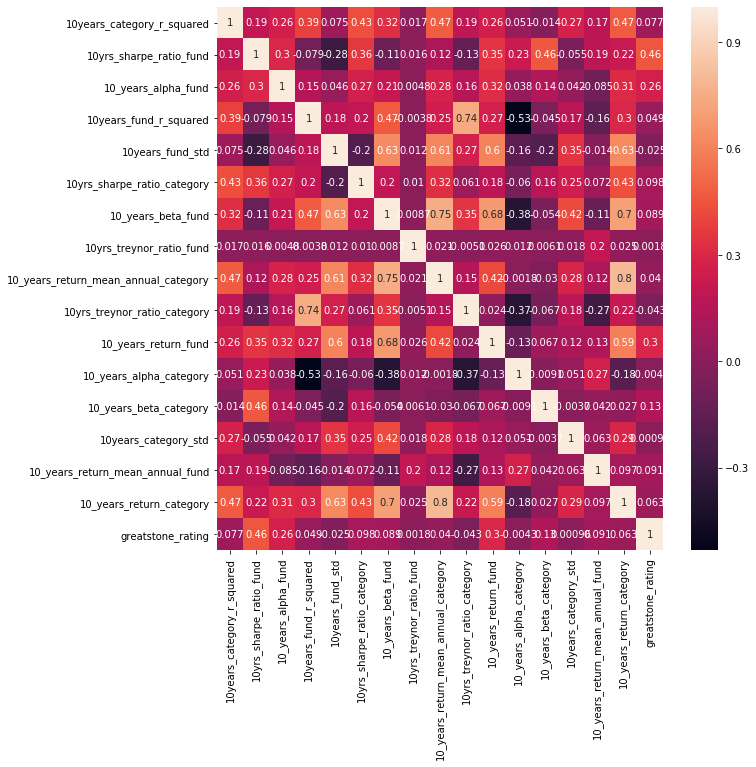

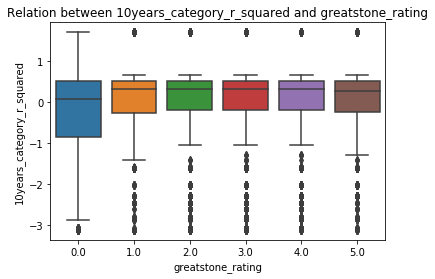

                         sum_sq       df           F        PR(>F)
greatstone_rating    117.326089      1.0  118.675778  1.474006e-27
Residual           19770.564636  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0    0.329  0.001  0.2211  0.4369   True
   0.0    2.0   0.4147  0.001  0.3268  0.5026   True
   0.0    3.0    0.447  0.001  0.3633  0.5308   True
   0.0    4.0   0.4594  0.001  0.3724  0.5464   True
   0.0    5.0   0.3744  0.001  0.2707   0.478   True
   1.0    2.0   0.0857 0.0597 -0.0019  0.1733  False
   1.0    3.0    0.118  0.001  0.0345  0.2015   True
   1.0    4.0   0.1304  0.001  0.0436  0.2171   True
   1.0    5.0   0.0453 0.7871 -0.0581  0.1487  False
   2.0    3.0   0.0323 0.5469  -0.023  0.0877  False
   2.0    4.0   0.0447 0.2779 -0.0154  0.1048  False
   2.0    5.0  -0.0404 0.7022 -0.1227   0.042  False
   3

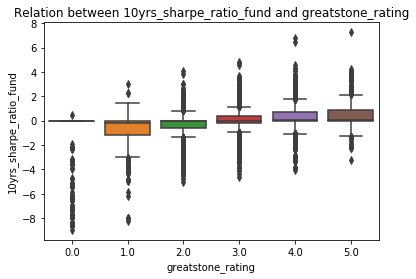

                         sum_sq       df            F  PR(>F)
greatstone_rating   1778.236660      1.0  2025.021663     0.0
Residual           17560.887065  19998.0          NaN     NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0    1.0  -0.3709 0.001  -0.472 -0.2698   True
   0.0    2.0   0.0092   0.9 -0.0731  0.0916  False
   0.0    3.0   0.3599 0.001  0.2814  0.4383   True
   0.0    4.0   0.6487 0.001  0.5672  0.7302   True
   0.0    5.0   0.8092 0.001  0.7121  0.9063   True
   1.0    2.0   0.3802 0.001   0.298  0.4623   True
   1.0    3.0   0.7308 0.001  0.6525   0.809   True
   1.0    4.0   1.0196 0.001  0.9384  1.1009   True
   1.0    5.0   1.1801 0.001  1.0832   1.277   True
   2.0    3.0   0.3506 0.001  0.2988  0.4025   True
   2.0    4.0   0.6395 0.001  0.5832  0.6958   True
   2.0    5.0      0.8 0.001  0.7228  0.8771   True
   3.0    4.0   0.2889 0.001  0.23

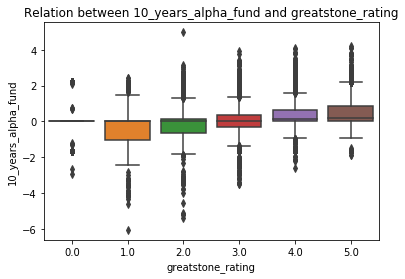

                         sum_sq       df           F         PR(>F)
greatstone_rating    792.181653      1.0  830.592074  5.429070e-179
Residual           19073.199945  19998.0         NaN            NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0847 0.2053 -0.1908 0.0215  False
   0.0    2.0   0.1276  0.001  0.0411 0.2141   True
   0.0    3.0   0.3061  0.001  0.2237 0.3886   True
   0.0    4.0   0.5159  0.001  0.4302 0.6015   True
   0.0    5.0   0.6334  0.001  0.5314 0.7354   True
   1.0    2.0   0.2123  0.001   0.126 0.2985   True
   1.0    3.0   0.3908  0.001  0.3086  0.473   True
   1.0    4.0   0.6005  0.001  0.5151 0.6859   True
   1.0    5.0   0.7181  0.001  0.6163 0.8198   True
   2.0    3.0   0.1786  0.001  0.1241  0.233   True
   2.0    4.0   0.3883  0.001  0.3291 0.4474   True
   2.0    5.0   0.5058  0.001  0.4248 0.5869   True
   3.0    4.0   

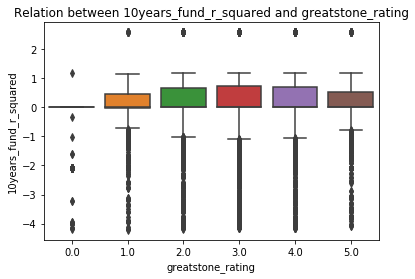

                         sum_sq       df          F    PR(>F)
greatstone_rating     21.167173      1.0  21.282887  0.000004
Residual           19889.271493  19998.0        NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0577 0.6336 -0.0508 0.1662  False
   0.0    2.0    0.146  0.001  0.0576 0.2345   True
   0.0    3.0   0.1733  0.001   0.089 0.2575   True
   0.0    4.0   0.1594  0.001  0.0719 0.2469   True
   0.0    5.0   0.1291 0.0056  0.0248 0.2333   True
   1.0    2.0   0.0883 0.0492  0.0002 0.1765   True
   1.0    3.0   0.1156 0.0012  0.0316 0.1995   True
   1.0    4.0   0.1017 0.0116  0.0145  0.189   True
   1.0    5.0   0.0713 0.3696 -0.0327 0.1754  False
   2.0    3.0   0.0272 0.7038 -0.0284 0.0829  False
   2.0    4.0   0.0134    0.9 -0.0471 0.0738  False
   2.0    5.0   -0.017    0.9 -0.0998 0.0658  False
   3.0    4.0  -0.0138    0.9 -0.0

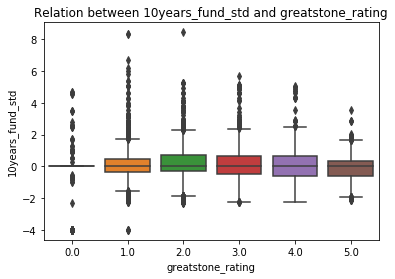

                         sum_sq       df         F    PR(>F)
greatstone_rating      5.871038      1.0  5.898454  0.015163
Residual           19905.048565  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.1161 0.0279  0.0076  0.2246   True
   0.0    2.0   0.1477  0.001  0.0593  0.2361   True
   0.0    3.0   0.0985 0.0112  0.0142  0.1828   True
   0.0    4.0   0.0549 0.4744 -0.0326  0.1424  False
   0.0    5.0  -0.0058    0.9   -0.11  0.0984  False
   1.0    2.0   0.0316    0.9 -0.0566  0.1198  False
   1.0    3.0  -0.0176    0.9 -0.1015  0.0664  False
   1.0    4.0  -0.0612 0.3439 -0.1484  0.0261  False
   1.0    5.0  -0.1219 0.0109 -0.2259 -0.0179   True
   2.0    3.0  -0.0492  0.119 -0.1048  0.0065  False
   2.0    4.0  -0.0928  0.001 -0.1532 -0.0323   True
   2.0    5.0  -0.1535  0.001 -0.2363 -0.0707   True
   3.0    4.0  -0.0436

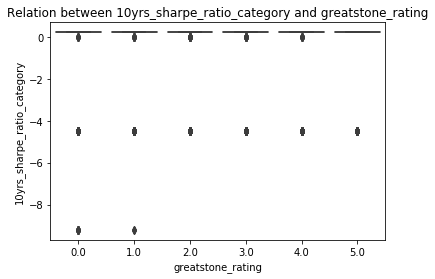

                         sum_sq       df           F        PR(>F)
greatstone_rating    195.053920      1.0  192.129982  1.732311e-43
Residual           20302.340448  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.3882  0.001  0.2788 0.4976   True
   0.0    2.0   0.4563  0.001  0.3672 0.5454   True
   0.0    3.0   0.4957  0.001  0.4108 0.5807   True
   0.0    4.0   0.5012  0.001   0.413 0.5894   True
   0.0    5.0   0.5412  0.001  0.4361 0.6462   True
   1.0    2.0   0.0681  0.245 -0.0208 0.1569  False
   1.0    3.0   0.1075  0.004  0.0229 0.1922   True
   1.0    4.0    0.113 0.0034  0.0251 0.2009   True
   1.0    5.0    0.153  0.001  0.0481 0.2578   True
   2.0    3.0   0.0394 0.3404 -0.0167 0.0955  False
   2.0    4.0   0.0449 0.2872  -0.016 0.1058  False
   2.0    5.0   0.0849 0.0437  0.0014 0.1683   True
   3.0    4.0   0.0

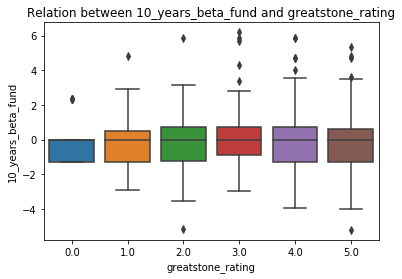

                         sum_sq       df          F        PR(>F)
greatstone_rating     92.121859      1.0  93.387117  4.805279e-22
Residual           19727.056679  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.3188  0.001  0.2111  0.4264   True
   0.0    2.0   0.4269  0.001  0.3392  0.5147   True
   0.0    3.0   0.4692  0.001  0.3856  0.5528   True
   0.0    4.0   0.4173  0.001  0.3305  0.5042   True
   0.0    5.0   0.3731  0.001  0.2697  0.4765   True
   1.0    2.0   0.1081 0.0057  0.0207  0.1956   True
   1.0    3.0   0.1504  0.001  0.0671  0.2338   True
   1.0    4.0   0.0985  0.015   0.012  0.1851   True
   1.0    5.0   0.0543 0.6421 -0.0488  0.1575  False
   2.0    3.0   0.0423 0.2453 -0.0129  0.0975  False
   2.0    4.0  -0.0096    0.9 -0.0696  0.0504  False
   2.0    5.0  -0.0538 0.4257  -0.136  0.0284  False
   3.0 

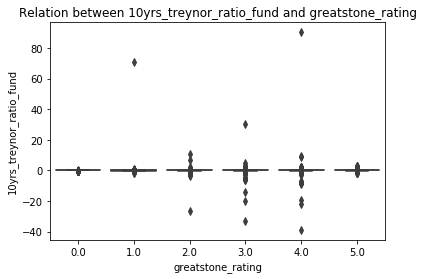

                         sum_sq       df        F    PR(>F)
greatstone_rating      0.020715      1.0  0.02065  0.885738
Residual           20061.176092  19998.0      NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0393    0.9 -0.0697 0.1484  False
   0.0    2.0  -0.0031    0.9  -0.092 0.0857  False
   0.0    3.0   0.0007    0.9  -0.084 0.0854  False
   0.0    4.0   0.0112    0.9 -0.0767 0.0992  False
   0.0    5.0   0.0153    0.9 -0.0895   0.12  False
   1.0    2.0  -0.0424 0.7208  -0.131 0.0462  False
   1.0    3.0  -0.0386 0.7554  -0.123 0.0458  False
   1.0    4.0  -0.0281    0.9 -0.1158 0.0596  False
   1.0    5.0  -0.0241    0.9 -0.1286 0.0805  False
   2.0    3.0   0.0038    0.9 -0.0521 0.0597  False
   2.0    4.0   0.0143    0.9 -0.0464 0.0751  False
   2.0    5.0   0.0184    0.9 -0.0649 0.1016  False
   3.0    4.0   0.0105    0.9 -0.0439  0

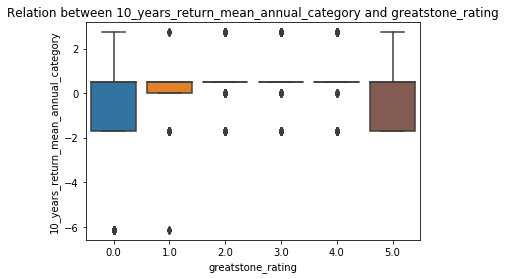

                         sum_sq       df          F        PR(>F)
greatstone_rating     31.392508      1.0  31.151829  2.417094e-08
Residual           20152.504394  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.2746  0.001  0.1657  0.3835   True
   0.0    2.0   0.3436  0.001  0.2549  0.4324   True
   0.0    3.0   0.3741  0.001  0.2895  0.4587   True
   0.0    4.0   0.3096  0.001  0.2217  0.3974   True
   0.0    5.0   0.2455  0.001  0.1408  0.3501   True
   1.0    2.0   0.0691 0.2267 -0.0194  0.1575  False
   1.0    3.0   0.0996 0.0099  0.0153  0.1838   True
   1.0    4.0    0.035 0.8512 -0.0526  0.1226  False
   1.0    5.0  -0.0291    0.9 -0.1335  0.0753  False
   2.0    3.0   0.0305 0.6101 -0.0254  0.0864  False
   2.0    4.0  -0.0341 0.5855 -0.0947  0.0266  False
   2.0    5.0  -0.0982   0.01 -0.1813  -0.015   True
   3.0 

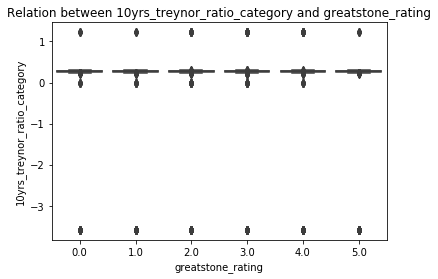

                         sum_sq       df          F        PR(>F)
greatstone_rating     37.455680      1.0  37.625112  8.734357e-10
Residual           19907.945746  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.1518  0.001 -0.2603 -0.0432   True
   0.0    2.0  -0.2018  0.001 -0.2903 -0.1134   True
   0.0    3.0    -0.22  0.001 -0.3043 -0.1357   True
   0.0    4.0  -0.2318  0.001 -0.3193 -0.1442   True
   0.0    5.0  -0.2065  0.001 -0.3108 -0.1022   True
   1.0    2.0  -0.0501  0.574 -0.1383  0.0381  False
   1.0    3.0  -0.0683 0.1873 -0.1523  0.0157  False
   1.0    4.0    -0.08 0.0939 -0.1673  0.0073  False
   1.0    5.0  -0.0547 0.6431 -0.1588  0.0493  False
   2.0    3.0  -0.0182    0.9 -0.0739  0.0375  False
   2.0    4.0  -0.0299 0.6943 -0.0904  0.0306  False
   2.0    5.0  -0.0046    0.9 -0.0875  0.0782  False
   3.0 

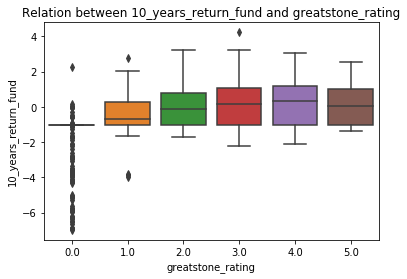

                         sum_sq       df            F  PR(>F)
greatstone_rating   1782.888534      1.0  1948.706426     0.0
Residual           18296.344906  19998.0          NaN     NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0    1.0   0.7928 0.001  0.6908  0.8949   True
   0.0    2.0   1.1101 0.001   1.027  1.1933   True
   0.0    3.0   1.3061 0.001  1.2269  1.3853   True
   0.0    4.0   1.4164 0.001  1.3341  1.4987   True
   0.0    5.0   1.3002 0.001  1.2022  1.3982   True
   1.0    2.0   0.3173 0.001  0.2344  0.4002   True
   1.0    3.0   0.5133 0.001  0.4343  0.5923   True
   1.0    4.0   0.6236 0.001  0.5415  0.7056   True
   1.0    5.0   0.5074 0.001  0.4096  0.6052   True
   2.0    3.0    0.196 0.001  0.1436  0.2483   True
   2.0    4.0   0.3062 0.001  0.2494  0.3631   True
   2.0    5.0   0.1901 0.001  0.1122   0.268   True
   3.0    4.0   0.1103 0.001  0.05

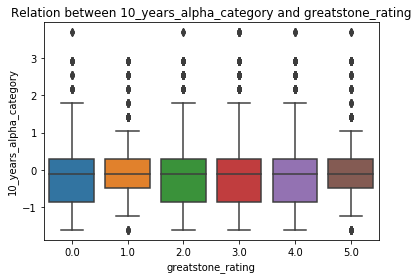

                         sum_sq       df        F    PR(>F)
greatstone_rating      0.374360      1.0  0.37677  0.539344
Residual           19870.070655  19998.0      NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.0979 0.1046 -0.2063  0.0106  False
   0.0    2.0  -0.0828 0.0815 -0.1712  0.0056  False
   0.0    3.0  -0.1068 0.0041 -0.1911 -0.0226   True
   0.0    4.0  -0.0547 0.4792 -0.1422  0.0328  False
   0.0    5.0  -0.0692 0.4079 -0.1734   0.035  False
   1.0    2.0    0.015    0.9 -0.0731  0.1032  False
   1.0    3.0   -0.009    0.9 -0.0929   0.075  False
   1.0    4.0   0.0432  0.694  -0.044  0.1304  False
   1.0    5.0   0.0286    0.9 -0.0754  0.1326  False
   2.0    3.0   -0.024 0.7988 -0.0796  0.0316  False
   2.0    4.0   0.0282 0.7422 -0.0323  0.0886  False
   2.0    5.0   0.0136    0.9 -0.0692  0.0964  False
   3.0    4.0   0.0522 0.

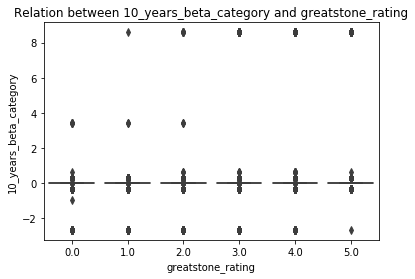

                         sum_sq       df           F        PR(>F)
greatstone_rating    357.841904      1.0  358.688232  2.687456e-79
Residual           19950.814545  19998.0         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0272    0.9 -0.1358 0.0815  False
   0.0    2.0   0.0933  0.032  0.0048 0.1818   True
   0.0    3.0   0.1771  0.001  0.0927 0.2615   True
   0.0    4.0   0.3601  0.001  0.2725 0.4478   True
   0.0    5.0   0.4431  0.001  0.3388 0.5475   True
   1.0    2.0   0.1205 0.0014  0.0322 0.2087   True
   1.0    3.0   0.2043  0.001  0.1202 0.2884   True
   1.0    4.0   0.3873  0.001  0.2999 0.4747   True
   1.0    5.0   0.4703  0.001  0.3662 0.5745   True
   2.0    3.0   0.0838  0.001  0.0281 0.1395   True
   2.0    4.0   0.2668  0.001  0.2063 0.3274   True
   2.0    5.0   0.3498  0.001  0.2669 0.4328   True
   3.0    4.0   0.1

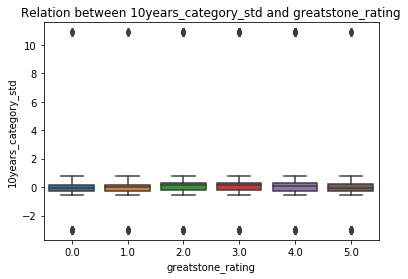

                         sum_sq       df        F    PR(>F)
greatstone_rating      0.016643      1.0  0.01753  0.894668
Residual           18985.353415  19998.0      NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0    0.058 0.6089 -0.0481 0.1641  False
   0.0    2.0   0.0852 0.0559 -0.0012 0.1716  False
   0.0    3.0   0.0718 0.1279 -0.0105 0.1542  False
   0.0    4.0   0.0583 0.3764 -0.0272 0.1439  False
   0.0    5.0   0.0234    0.9 -0.0785 0.1253  False
   1.0    2.0   0.0272    0.9 -0.0589 0.1134  False
   1.0    3.0   0.0138    0.9 -0.0682 0.0959  False
   1.0    4.0   0.0004    0.9 -0.0849 0.0856  False
   1.0    5.0  -0.0346    0.9 -0.1362 0.0671  False
   2.0    3.0  -0.0134    0.9 -0.0678  0.041  False
   2.0    4.0  -0.0269 0.7604  -0.086 0.0322  False
   2.0    5.0  -0.0618 0.2488 -0.1428 0.0191  False
   3.0    4.0  -0.0135    0.9 -0.0665 0.

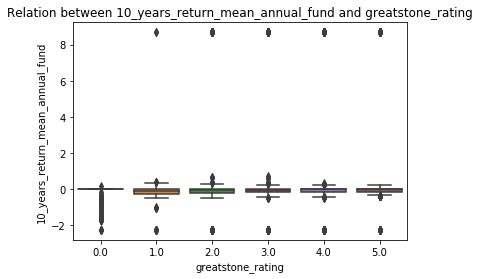

                         sum_sq       df          F        PR(>F)
greatstone_rating     69.827168      1.0  72.069061  2.220985e-17
Residual           19375.910882  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   -0.063 0.5403 -0.1702 0.0441  False
   0.0    2.0  -0.0013    0.9 -0.0886  0.086  False
   0.0    3.0   0.0651 0.2232  -0.018 0.1483  False
   0.0    4.0   0.1489  0.001  0.0625 0.2353   True
   0.0    5.0   0.1356 0.0024  0.0327 0.2385   True
   1.0    2.0   0.0617 0.3297 -0.0253 0.1488  False
   1.0    3.0   0.1282  0.001  0.0453 0.2111   True
   1.0    4.0    0.212  0.001  0.1258 0.2981   True
   1.0    5.0   0.1987  0.001   0.096 0.3013   True
   2.0    3.0   0.0664 0.0075  0.0115 0.1214   True
   2.0    4.0   0.1502  0.001  0.0905 0.2099   True
   2.0    5.0   0.1369  0.001  0.0552 0.2187   True
   3.0    4.0   0.0838

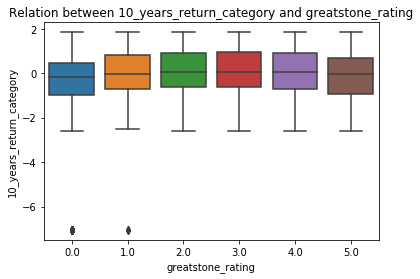

                         sum_sq       df          F        PR(>F)
greatstone_rating     80.119799      1.0  79.630374  4.895373e-19
Residual           20120.911719  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.3592  0.001  0.2507  0.4678   True
   0.0    2.0    0.477  0.001  0.3885  0.5654   True
   0.0    3.0   0.5104  0.001  0.4261  0.5947   True
   0.0    4.0   0.4473  0.001  0.3597  0.5348   True
   0.0    5.0   0.3613  0.001   0.257  0.4655   True
   1.0    2.0   0.1177  0.002  0.0295  0.2059   True
   1.0    3.0   0.1511  0.001  0.0671  0.2351   True
   1.0    4.0    0.088 0.0467  0.0007  0.1753   True
   1.0    5.0    0.002    0.9  -0.102  0.1061  False
   2.0    3.0   0.0334 0.5216 -0.0223  0.0891  False
   2.0    4.0  -0.0297 0.7009 -0.0902  0.0308  False
   2.0    5.0  -0.1157  0.001 -0.1986 -0.0328   True
   3.0 

In [121]:
handle_return10year = HandleData('return_10year.csv')
handle_data_references.append(handle_return10year)
handle_return10year.read_data()
# handle_return10year.drop_columns(['fund_name'])
# handle_return10year.handle_categorydata(['currency', 'fund_size'])
handle_return10year.describe_data()
handle_return10year.handle_outliers()
handle_return10year.show_correlation(figsize = (10,10))
handle_return10year.handle_missingvalues()
handle_return10year.describe_data()
handle_return10year.show_pairwise()
if handle_return10year.check_correlation():
    print("Has correlation")
    print(handle_return10year.correlated_cols_list)
else:
    print('No correlation')

In [122]:
# handle_return10year.correlated_cols_list.append('10yrs_sharpe_ratio_fund')
# handle_return10year.correlated_cols_list.append('10_years_alpha_fund')
# handle_return10year.correlated_cols_list.append('10_years_return_fund')
# handle_return10year.correlated_cols_list.append('10_years_beta_category')
handle_return10year.correlated_cols_list

['10yrs_sharpe_ratio_fund',
 '10_years_alpha_fund',
 '10_years_return_fund',
 '10_years_beta_category',
 '10years_fund_std',
 '10_years_beta_fund',
 '10_years_return_category']

In [123]:
handle_return10year.df.columns

Index(['10years_category_r_squared', '10yrs_sharpe_ratio_fund',
       '10_years_alpha_fund', '10years_fund_r_squared', '10years_fund_std',
       '10yrs_sharpe_ratio_category', '10_years_beta_fund',
       '10yrs_treynor_ratio_fund', 'fund_id',
       '10_years_return_mean_annual_category', '10yrs_treynor_ratio_category',
       '10_years_return_fund', '10_years_alpha_category',
       '10_years_beta_category', '10years_category_std',
       '10_years_return_mean_annual_fund', '10_years_return_category',
       'greatstone_rating'],
      dtype='object')

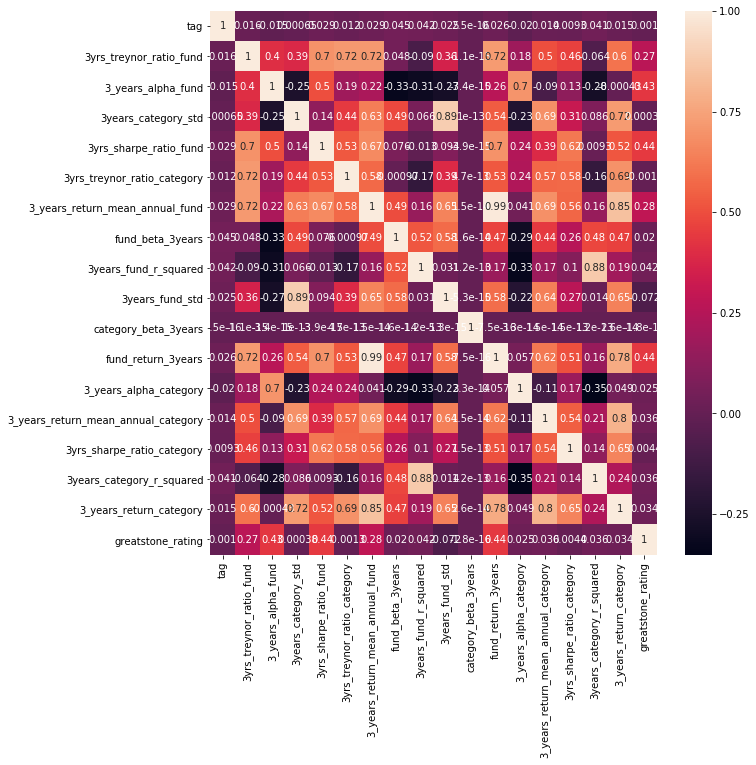

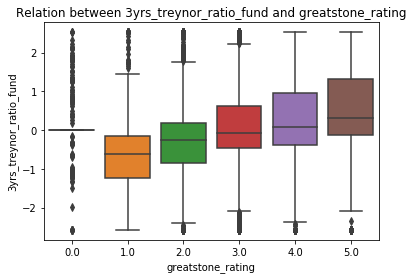

                         sum_sq       df            F         PR(>F)
greatstone_rating    960.257412      1.0  1014.014994  4.162239e-217
Residual           18937.814364  19998.0          NaN            NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0    1.0   -0.685 0.001 -0.7891 -0.5808   True
   0.0    2.0  -0.3086 0.001 -0.3935 -0.2237   True
   0.0    3.0   0.0122   0.9 -0.0687  0.0931  False
   0.0    4.0   0.2096 0.001  0.1256  0.2936   True
   0.0    5.0    0.464 0.001  0.3639   0.564   True
   1.0    2.0   0.3764 0.001  0.2917   0.461   True
   1.0    3.0   0.6971 0.001  0.6165  0.7778   True
   1.0    4.0   0.8945 0.001  0.8108  0.9783   True
   1.0    5.0   1.1489 0.001  1.0491  1.2488   True
   2.0    3.0   0.3208 0.001  0.2673  0.3742   True
   2.0    4.0   0.5182 0.001  0.4601  0.5762   True
   2.0    5.0   0.7726 0.001   0.693  0.8521   True
   3.0    4.0

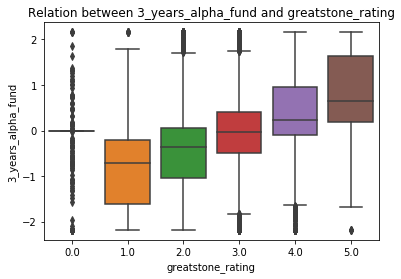

                         sum_sq       df            F  PR(>F)
greatstone_rating   2483.799671      1.0  2849.138029     0.0
Residual           17433.702866  19998.0          NaN     NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0    1.0  -0.7836 0.001 -0.8816 -0.6857   True
   0.0    2.0  -0.4051 0.001 -0.4849 -0.3253   True
   0.0    3.0   0.0235   0.9 -0.0526  0.0995  False
   0.0    4.0   0.4564 0.001  0.3774  0.5354   True
   0.0    5.0   0.8843 0.001  0.7902  0.9784   True
   1.0    2.0   0.3785 0.001   0.299  0.4581   True
   1.0    3.0   0.8071 0.001  0.7313  0.8829   True
   1.0    4.0     1.24 0.001  1.1613  1.3188   True
   1.0    5.0   1.6679 0.001  1.5741  1.7618   True
   2.0    3.0   0.4285 0.001  0.3783  0.4788   True
   2.0    4.0   0.8615 0.001  0.8069   0.916   True
   2.0    5.0   1.2894 0.001  1.2146  1.3642   True
   3.0    4.0   0.4329 0.001   0.3

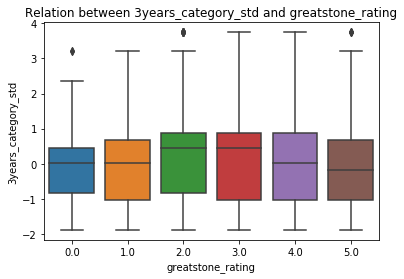

                         sum_sq       df         F   PR(>F)
greatstone_rating      0.002775      1.0  0.002776  0.95798
Residual           19986.780158  19998.0       NaN      NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.0181    0.9 -0.1267  0.0905  False
   0.0    2.0   0.1294  0.001  0.0408  0.2179   True
   0.0    3.0   0.1458  0.001  0.0615  0.2302   True
   0.0    4.0   0.0733 0.1617 -0.0143  0.1609  False
   0.0    5.0  -0.0363    0.9 -0.1407   0.068  False
   1.0    2.0   0.1475  0.001  0.0592  0.2357   True
   1.0    3.0   0.1639  0.001  0.0798   0.248   True
   1.0    4.0   0.0914 0.0341  0.0041  0.1787   True
   1.0    5.0  -0.0182    0.9 -0.1223  0.0859  False
   2.0    3.0   0.0164    0.9 -0.0393  0.0721  False
   2.0    4.0  -0.0561 0.0878 -0.1166  0.0045  False
   2.0    5.0  -0.1657  0.001 -0.2486 -0.0828   True
   3.0    4.0  -0.0725 0.

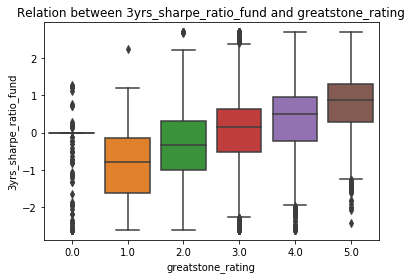

                         sum_sq       df            F  PR(>F)
greatstone_rating   2621.442152      1.0  3042.199184     0.0
Residual           17232.139308  19998.0          NaN     NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0    1.0  -0.7581 0.001 -0.8563 -0.6599   True
   0.0    2.0  -0.2438 0.001 -0.3238 -0.1638   True
   0.0    3.0   0.1998 0.001  0.1236  0.2761   True
   0.0    4.0    0.534 0.001  0.4548  0.6132   True
   0.0    5.0   0.9628 0.001  0.8685  1.0571   True
   1.0    2.0   0.5142 0.001  0.4345   0.594   True
   1.0    3.0   0.9579 0.001  0.8819  1.0339   True
   1.0    4.0   1.2921 0.001  1.2131   1.371   True
   1.0    5.0   1.7209 0.001  1.6268   1.815   True
   2.0    3.0   0.4436 0.001  0.3933   0.494   True
   2.0    4.0   0.7778 0.001  0.7231  0.8326   True
   2.0    5.0   1.2066 0.001  1.1317  1.2816   True
   3.0    4.0   0.3342 0.001  0.28

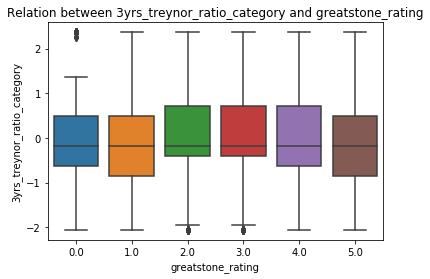

                         sum_sq       df         F    PR(>F)
greatstone_rating      0.033474      1.0  0.033485  0.854809
Residual           19991.333563  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.0526 0.7125 -0.1614  0.0561  False
   0.0    2.0   0.0376  0.811  -0.051  0.1262  False
   0.0    3.0   0.0751 0.1146 -0.0094  0.1595  False
   0.0    4.0   0.0269    0.9 -0.0608  0.1146  False
   0.0    5.0  -0.0734 0.3408 -0.1779  0.0311  False
   1.0    2.0   0.0902 0.0422  0.0018  0.1785   True
   1.0    3.0   0.1277  0.001  0.0435  0.2119   True
   1.0    4.0   0.0795 0.0993 -0.0079  0.1669  False
   1.0    5.0  -0.0208    0.9  -0.125  0.0835  False
   2.0    3.0   0.0375 0.3935 -0.0183  0.0933  False
   2.0    4.0  -0.0107    0.9 -0.0713  0.0499  False
   2.0    5.0   -0.111 0.0019  -0.194  -0.028   True
   3.0    4.0  -0.0482

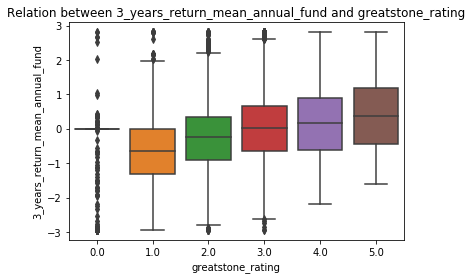

                         sum_sq       df            F         PR(>F)
greatstone_rating   1079.643752      1.0  1144.312507  5.614280e-244
Residual           18867.849141  19998.0          NaN            NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0    1.0  -0.4631 0.001  -0.568 -0.3583   True
   0.0    2.0  -0.0801 0.081 -0.1655  0.0053  False
   0.0    3.0   0.2153 0.001  0.1339  0.2967   True
   0.0    4.0   0.3896 0.001   0.305  0.4741   True
   0.0    5.0   0.6136 0.001  0.5129  0.7143   True
   1.0    2.0    0.383 0.001  0.2979  0.4682   True
   1.0    3.0   0.6784 0.001  0.5973  0.7595   True
   1.0    4.0   0.8527 0.001  0.7684   0.937   True
   1.0    5.0   1.0767 0.001  0.9763  1.1772   True
   2.0    3.0   0.2954 0.001  0.2416  0.3491   True
   2.0    4.0   0.4697 0.001  0.4113  0.5281   True
   2.0    5.0   0.6937 0.001  0.6137  0.7737   True
   3.0    4.0

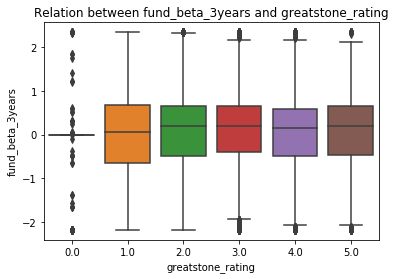

                         sum_sq       df         F    PR(>F)
greatstone_rating      5.525084      1.0  5.555889  0.018428
Residual           19887.118320  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0     0.08 0.2861 -0.0285 0.1886  False
   0.0    2.0   0.1322  0.001  0.0437 0.2206   True
   0.0    3.0   0.1333  0.001   0.049 0.2176   True
   0.0    4.0   0.0943 0.0261  0.0068 0.1818   True
   0.0    5.0    0.127 0.0069  0.0228 0.2313   True
   1.0    2.0   0.0521 0.5362 -0.0361 0.1403  False
   1.0    3.0   0.0532 0.4632 -0.0308 0.1372  False
   1.0    4.0   0.0142    0.9  -0.073 0.1015  False
   1.0    5.0    0.047 0.7659 -0.0571  0.151  False
   2.0    3.0   0.0011    0.9 -0.0545 0.0568  False
   2.0    4.0  -0.0379 0.4772 -0.0983 0.0226  False
   2.0    5.0  -0.0051    0.9  -0.088 0.0777  False
   3.0    4.0   -0.039 0.3142 -0.0932

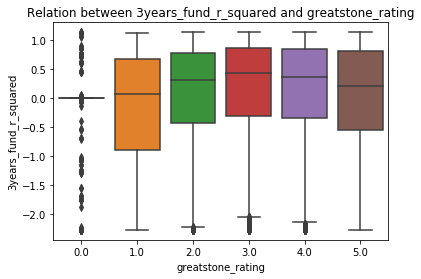

                         sum_sq       df          F        PR(>F)
greatstone_rating     24.813575      1.0  24.978799  5.845364e-07
Residual           19865.721756  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.1676  0.001 -0.2758 -0.0593   True
   0.0    2.0    0.051 0.5573 -0.0372  0.1392  False
   0.0    3.0   0.1223  0.001  0.0382  0.2064   True
   0.0    4.0   0.1017 0.0117  0.0143   0.189   True
   0.0    5.0  -0.0058    0.9 -0.1098  0.0982  False
   1.0    2.0   0.2186  0.001  0.1306  0.3065   True
   1.0    3.0   0.2898  0.001  0.2061  0.3736   True
   1.0    4.0   0.2692  0.001  0.1822  0.3563   True
   1.0    5.0   0.1618  0.001   0.058  0.2656   True
   2.0    3.0   0.0713 0.0035  0.0158  0.1268   True
   2.0    4.0   0.0506 0.1589 -0.0097   0.111  False
   2.0    5.0  -0.0568  0.368 -0.1394  0.0259  False
   3.0 

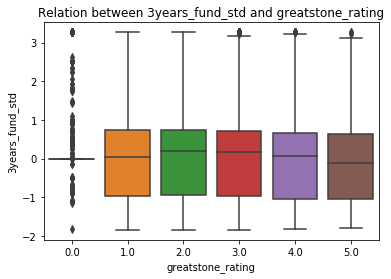

                         sum_sq       df          F        PR(>F)
greatstone_rating     69.388068      1.0  69.888022  6.682680e-17
Residual           19854.941555  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.0567 0.6482 -0.1652  0.0517  False
   0.0    2.0  -0.0681 0.2394 -0.1565  0.0203  False
   0.0    3.0  -0.0996 0.0098 -0.1838 -0.0153   True
   0.0    4.0  -0.1773  0.001 -0.2648 -0.0898   True
   0.0    5.0  -0.2367  0.001 -0.3409 -0.1325   True
   1.0    2.0  -0.0114    0.9 -0.0995  0.0767  False
   1.0    3.0  -0.0429 0.6688 -0.1268  0.0411  False
   1.0    4.0  -0.1206 0.0012 -0.2078 -0.0333   True
   1.0    5.0    -0.18  0.001 -0.2839  -0.076   True
   2.0    3.0  -0.0315 0.5777 -0.0871  0.0242  False
   2.0    4.0  -0.1092  0.001 -0.1696 -0.0487   True
   2.0    5.0  -0.1686  0.001 -0.2514 -0.0858   True
   3.0 

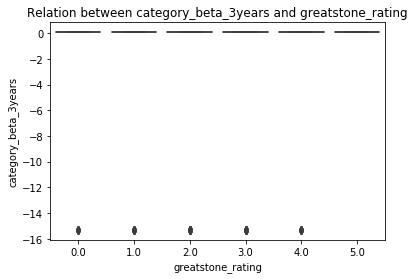

                         sum_sq       df          F        PR(>F)
greatstone_rating     26.003248      1.0  26.922694  2.138253e-07
Residual           19315.041918  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0437 0.8359 -0.1507 0.0632  False
   0.0    2.0   0.0403 0.7473 -0.0468 0.1275  False
   0.0    3.0   0.0787 0.0758 -0.0044 0.1617  False
   0.0    4.0   0.0807 0.0829 -0.0056  0.167  False
   0.0    5.0    0.124 0.0077  0.0212 0.2268   True
   1.0    2.0   0.0841 0.0648 -0.0028  0.171  False
   1.0    3.0   0.1224  0.001  0.0396 0.2052   True
   1.0    4.0   0.1244  0.001  0.0384 0.2104   True
   1.0    5.0   0.1678  0.001  0.0652 0.2703   True
   2.0    3.0   0.0383  0.348 -0.0165 0.0932  False
   2.0    4.0   0.0403 0.3867 -0.0193 0.0999  False
   2.0    5.0   0.0837 0.0409   0.002 0.1653   True
   3.0    4.0    0.002

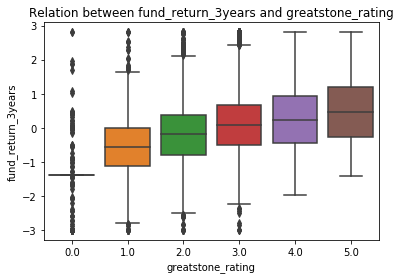

                         sum_sq       df            F  PR(>F)
greatstone_rating   3789.300756      1.0  4696.883772     0.0
Residual           16133.768726  19998.0          NaN     NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   0.0    1.0   0.8606 0.001 0.7642  0.957   True
   0.0    2.0    1.236 0.001 1.1575 1.3146   True
   0.0    3.0   1.5326 0.001 1.4577 1.6074   True
   0.0    4.0    1.714 0.001 1.6363 1.7918   True
   0.0    5.0   1.9458 0.001 1.8532 2.0383   True
   1.0    2.0   0.3755 0.001 0.2972 0.4538   True
   1.0    3.0    0.672 0.001 0.5974 0.7466   True
   1.0    4.0   0.8534 0.001 0.7759  0.931   True
   1.0    5.0   1.0852 0.001 0.9928 1.1776   True
   2.0    3.0   0.2965 0.001 0.2471  0.346   True
   2.0    4.0    0.478 0.001 0.4243 0.5317   True
   2.0    5.0   0.7097 0.001 0.6361 0.7833   True
   3.0    4.0   0.1814 0.001 0.1333 0.2296   True
   3.0    5.

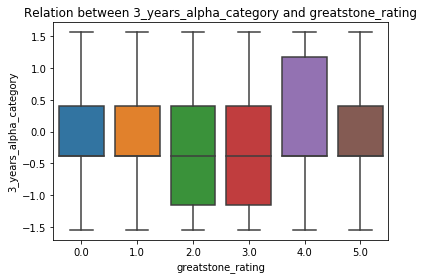

                         sum_sq       df          F    PR(>F)
greatstone_rating     12.249236      1.0  12.349586  0.000442
Residual           19835.501975  19998.0        NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0    0.004    0.9 -0.1044 0.1124  False
   0.0    2.0  -0.0403 0.7583 -0.1286  0.048  False
   0.0    3.0  -0.0186    0.9 -0.1028 0.0655  False
   0.0    4.0   0.0396 0.7628 -0.0478 0.1271  False
   0.0    5.0   0.0874  0.159 -0.0167 0.1915  False
   1.0    2.0  -0.0443 0.6804 -0.1324 0.0437  False
   1.0    3.0  -0.0227    0.9 -0.1066 0.0612  False
   1.0    4.0   0.0356 0.8368 -0.0516 0.1227  False
   1.0    5.0   0.0833 0.1995 -0.0205 0.1872  False
   2.0    3.0   0.0216 0.8679 -0.0339 0.0772  False
   2.0    4.0   0.0799 0.0023  0.0195 0.1403   True
   2.0    5.0   0.1277  0.001  0.0449 0.2104   True
   3.0    4.0   0.0583 0.0263  0.0

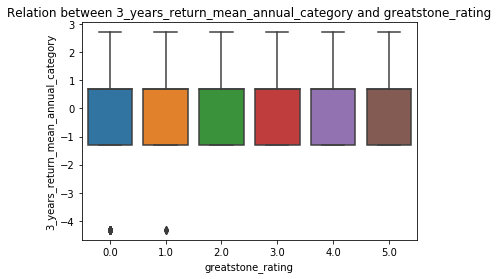

                         sum_sq       df          F        PR(>F)
greatstone_rating     25.569982      1.0  25.463834  4.547042e-07
Residual           20081.362995  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.2213  0.001  0.1126    0.33   True
   0.0    2.0   0.3487  0.001  0.2601  0.4372   True
   0.0    3.0   0.3601  0.001  0.2757  0.4445   True
   0.0    4.0   0.2993  0.001  0.2116   0.387   True
   0.0    5.0   0.2041  0.001  0.0997  0.3085   True
   1.0    2.0   0.1273  0.001   0.039  0.2156   True
   1.0    3.0   0.1388  0.001  0.0547  0.2229   True
   1.0    4.0    0.078  0.112 -0.0094  0.1654  False
   1.0    5.0  -0.0172    0.9 -0.1214   0.087  False
   2.0    3.0   0.0114    0.9 -0.0443  0.0672  False
   2.0    4.0  -0.0494 0.1848 -0.1099  0.0112  False
   2.0    5.0  -0.1445  0.001 -0.2275 -0.0616   True
   3.0 

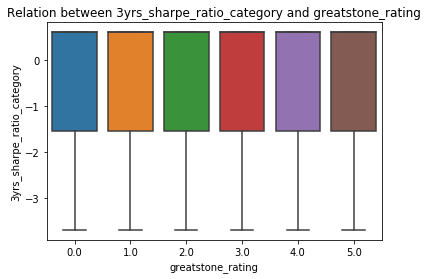

                         sum_sq       df         F    PR(>F)
greatstone_rating      0.382871      1.0  0.381681  0.536712
Residual           20060.348718  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0    0.024    0.9 -0.0851  0.133  False
   0.0    2.0   0.0493 0.5953 -0.0395 0.1381  False
   0.0    3.0    0.084 0.0533 -0.0007 0.1686  False
   0.0    4.0   0.0324    0.9 -0.0555 0.1203  False
   0.0    5.0   0.0236    0.9 -0.0812 0.1283  False
   1.0    2.0   0.0254    0.9 -0.0632 0.1139  False
   1.0    3.0     0.06 0.3264 -0.0243 0.1444  False
   1.0    4.0   0.0084    0.9 -0.0792 0.0961  False
   1.0    5.0  -0.0004    0.9 -0.1049 0.1041  False
   2.0    3.0   0.0347 0.4876 -0.0212 0.0906  False
   2.0    4.0  -0.0169    0.9 -0.0777 0.0438  False
   2.0    5.0  -0.0258    0.9  -0.109 0.0575  False
   3.0    4.0  -0.0516 0.0754  -0.106

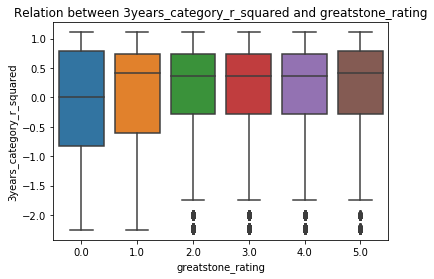

                         sum_sq       df         F        PR(>F)
greatstone_rating     25.400291      1.0  25.52871  4.396876e-07
Residual           19897.403044  19998.0       NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1565  0.001   0.048 0.2651   True
   0.0    2.0   0.1749  0.001  0.0864 0.2633   True
   0.0    3.0   0.1871  0.001  0.1028 0.2714   True
   0.0    4.0   0.1731  0.001  0.0855 0.2606   True
   0.0    5.0   0.2267  0.001  0.1225  0.331   True
   1.0    2.0   0.0183    0.9 -0.0699 0.1065  False
   1.0    3.0   0.0306    0.9 -0.0534 0.1146  False
   1.0    4.0   0.0165    0.9 -0.0708 0.1038  False
   1.0    5.0   0.0702 0.3898 -0.0339 0.1742  False
   2.0    3.0   0.0123    0.9 -0.0434 0.0679  False
   2.0    4.0  -0.0018    0.9 -0.0623 0.0587  False
   2.0    5.0   0.0519 0.4773  -0.031 0.1347  False
   3.0    4.0  -0.0141   

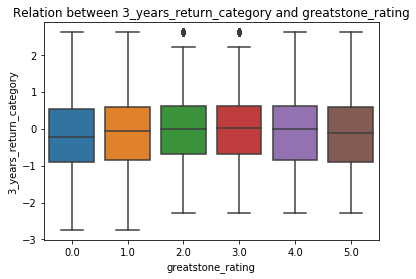

                         sum_sq       df         F    PR(>F)
greatstone_rating     22.885202      1.0  22.86232  0.000002
Residual           20018.014987  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.1818  0.001  0.0732  0.2904   True
   0.0    2.0   0.2805  0.001   0.192   0.369   True
   0.0    3.0   0.3188  0.001  0.2344  0.4031   True
   0.0    4.0   0.2564  0.001  0.1688   0.344   True
   0.0    5.0   0.1709  0.001  0.0666  0.2752   True
   1.0    2.0   0.0987 0.0181  0.0104  0.1869   True
   1.0    3.0   0.1369  0.001  0.0529   0.221   True
   1.0    4.0   0.0746 0.1442 -0.0127   0.162  False
   1.0    5.0  -0.0109    0.9  -0.115  0.0932  False
   2.0    3.0   0.0383 0.3677 -0.0174   0.094  False
   2.0    4.0   -0.024  0.855 -0.0846  0.0365  False
   2.0    5.0  -0.1096 0.0023 -0.1925 -0.0267   True
   3.0    4.0  -0.0623

In [124]:
handle_return3year = HandleData('return_3year.csv')
handle_data_references.append(handle_return3year)
handle_return3year.read_data()
# handle_return3year.drop_columns(['fund_name'])
# handle_return3year.handle_categorydata(['currency', 'fund_size'])
handle_return3year.describe_data()
handle_return3year.handle_outliers()
handle_return3year.show_correlation(figsize = (10,10))
handle_return3year.handle_missingvalues()
handle_return3year.describe_data()
handle_return3year.show_pairwise()
if handle_return3year.check_correlation():
    print("Has correlation")
    print(handle_return3year.correlated_cols_list)
else:
    print('No correlation')

In [125]:
# handle_return3year.correlated_cols_list.append('3yrs_treynor_ratio_fund')
# handle_return3year.correlated_cols_list.append('3_years_alpha_fund')
# handle_return3year.correlated_cols_list.append('3yrs_sharpe_ratio_fund')
# handle_return3year.correlated_cols_list.append('3_years_return_mean_annual_fund')
# handle_return3year.correlated_cols_list.append('3years_fund_std')
# handle_return3year.correlated_cols_list.append('fund_return_3years')
handle_return3year.correlated_cols_list

['3yrs_treynor_ratio_fund',
 '3_years_alpha_fund',
 '3yrs_sharpe_ratio_fund',
 '3_years_return_mean_annual_fund',
 'fund_return_3years',
 '3yrs_treynor_ratio_category',
 '3_years_return_mean_annual_category',
 '3_years_return_category',
 '3_years_alpha_category',
 '3yrs_treynor_ratio_category',
 '3yrs_sharpe_ratio_category',
 '3_years_return_category',
 '3years_category_std',
 '3yrs_treynor_ratio_category',
 '3years_fund_std',
 '3_years_return_mean_annual_category',
 '3yrs_sharpe_ratio_category',
 '3_years_return_category',
 '3years_category_std',
 '3yrs_treynor_ratio_category',
 '3years_fund_std',
 '3_years_return_mean_annual_category',
 '3yrs_sharpe_ratio_category',
 '3_years_return_category']

In [126]:
handle_return3year.df.columns

Index(['tag', '3yrs_treynor_ratio_fund', '3_years_alpha_fund',
       '3years_category_std', '3yrs_sharpe_ratio_fund',
       '3yrs_treynor_ratio_category', '3_years_return_mean_annual_fund',
       'fund_beta_3years', '3years_fund_r_squared', '3years_fund_std',
       'category_beta_3years', 'fund_return_3years', '3_years_alpha_category',
       '3_years_return_mean_annual_category', '3yrs_sharpe_ratio_category',
       '3years_category_r_squared', '3_years_return_category',
       'greatstone_rating'],
      dtype='object')

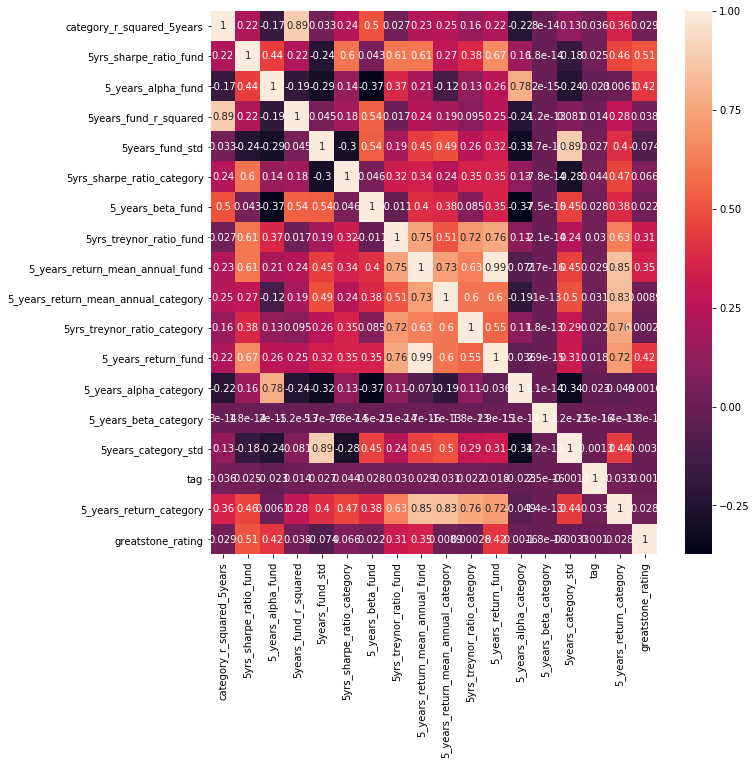

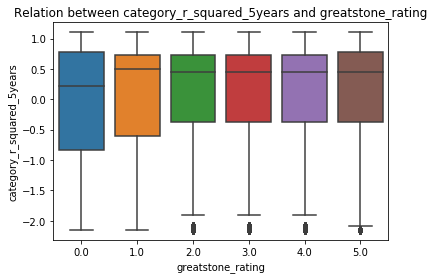

                         sum_sq       df          F    PR(>F)
greatstone_rating     16.429196      1.0  16.500077  0.000049
Residual           19912.092759  19998.0        NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1293  0.009  0.0207 0.2379   True
   0.0    2.0   0.1495  0.001   0.061  0.238   True
   0.0    3.0   0.1617  0.001  0.0774  0.246   True
   0.0    4.0   0.1441  0.001  0.0565 0.2317   True
   0.0    5.0   0.1829  0.001  0.0786 0.2872   True
   1.0    2.0   0.0202    0.9  -0.068 0.1085  False
   1.0    3.0   0.0324 0.8751 -0.0517 0.1164  False
   1.0    4.0   0.0147    0.9 -0.0726 0.1021  False
   1.0    5.0   0.0536 0.6612 -0.0505 0.1577  False
   2.0    3.0   0.0121    0.9 -0.0435 0.0678  False
   2.0    4.0  -0.0055    0.9  -0.066  0.055  False
   2.0    5.0   0.0334  0.846 -0.0495 0.1163  False
   3.0    4.0  -0.0176    0.9 -0.0

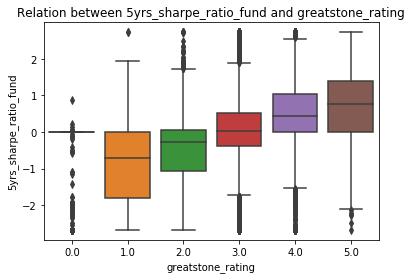

                         sum_sq       df            F  PR(>F)
greatstone_rating   3081.922852      1.0  3616.046792     0.0
Residual           17044.108310  19998.0          NaN     NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0    1.0  -0.7625 0.001 -0.8597 -0.6653   True
   0.0    2.0  -0.2833 0.001 -0.3625 -0.2041   True
   0.0    3.0   0.2183 0.001  0.1428  0.2938   True
   0.0    4.0   0.6283 0.001  0.5498  0.7067   True
   0.0    5.0   0.9922 0.001  0.8988  1.0856   True
   1.0    2.0   0.4792 0.001  0.4002  0.5582   True
   1.0    3.0   0.9808 0.001  0.9056  1.0561   True
   1.0    4.0   1.3908 0.001  1.3126  1.4689   True
   1.0    5.0   1.7547 0.001  1.6615  1.8479   True
   2.0    3.0   0.5017 0.001  0.4518  0.5515   True
   2.0    4.0   0.9116 0.001  0.8574  0.9657   True
   2.0    5.0   1.2755 0.001  1.2013  1.3497   True
   3.0    4.0   0.4099 0.001  0.36

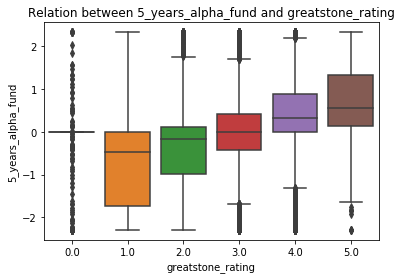

                         sum_sq       df            F  PR(>F)
greatstone_rating   2099.958800      1.0  2356.409401     0.0
Residual           17821.595886  19998.0          NaN     NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0    1.0  -0.7515 0.001 -0.8512 -0.6517   True
   0.0    2.0  -0.3536 0.001 -0.4349 -0.2723   True
   0.0    3.0   0.0276   0.9 -0.0498   0.105  False
   0.0    4.0   0.4375 0.001   0.357  0.5179   True
   0.0    5.0   0.7809 0.001  0.6851  0.8767   True
   1.0    2.0   0.3979 0.001  0.3169  0.4789   True
   1.0    3.0   0.7791 0.001  0.7019  0.8563   True
   1.0    4.0    1.189 0.001  1.1088  1.2692   True
   1.0    5.0   1.5324 0.001  1.4368   1.628   True
   2.0    3.0   0.3812 0.001    0.33  0.4323   True
   2.0    4.0   0.7911 0.001  0.7355  0.8467   True
   2.0    5.0   1.1345 0.001  1.0584  1.2106   True
   3.0    4.0   0.4099 0.001  0.36

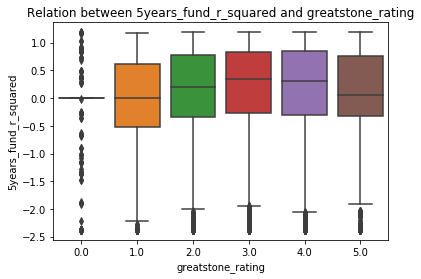

                         sum_sq       df          F    PR(>F)
greatstone_rating     17.135242      1.0  17.196941  0.000034
Residual           19926.251762  19998.0        NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.1101 0.0446 -0.2186 -0.0015   True
   0.0    2.0   0.0294    0.9  -0.059  0.1179  False
   0.0    3.0   0.1002 0.0093  0.0159  0.1845   True
   0.0    4.0   0.0798  0.098 -0.0078  0.1673  False
   0.0    5.0   0.0107    0.9 -0.0936   0.115  False
   1.0    2.0   0.1395  0.001  0.0513  0.2277   True
   1.0    3.0   0.2103  0.001  0.1262  0.2943   True
   1.0    4.0   0.1899  0.001  0.1026  0.2772   True
   1.0    5.0   0.1208 0.0121  0.0168  0.2249   True
   2.0    3.0   0.0707  0.004  0.0151  0.1264   True
   2.0    4.0   0.0503 0.1666 -0.0102  0.1108  False
   2.0    5.0  -0.0187    0.9 -0.1016  0.0641  False
   3.0    4.0  -0.0

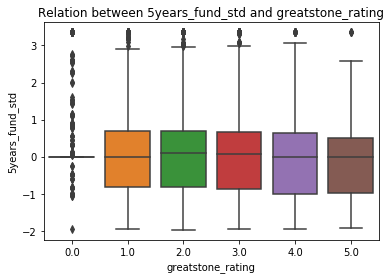

                         sum_sq       df          F        PR(>F)
greatstone_rating     66.466676      1.0  66.743455  3.274534e-16
Residual           19915.070141  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.0618 0.5731 -0.1704  0.0469  False
   0.0    2.0  -0.0727 0.1776 -0.1612  0.0158  False
   0.0    3.0  -0.1036 0.0062  -0.188 -0.0193   True
   0.0    4.0  -0.1749  0.001 -0.2625 -0.0872   True
   0.0    5.0  -0.2383  0.001 -0.3427  -0.134   True
   1.0    2.0  -0.0109    0.9 -0.0992  0.0773  False
   1.0    3.0  -0.0419 0.6897 -0.1259  0.0422  False
   1.0    4.0  -0.1131 0.0031 -0.2005 -0.0257   True
   1.0    5.0  -0.1765  0.001 -0.2807 -0.0724   True
   2.0    3.0  -0.0309 0.5959 -0.0866  0.0248  False
   2.0    4.0  -0.1022  0.001 -0.1627 -0.0416   True
   2.0    5.0  -0.1656  0.001 -0.2485 -0.0827   True
   3.0 

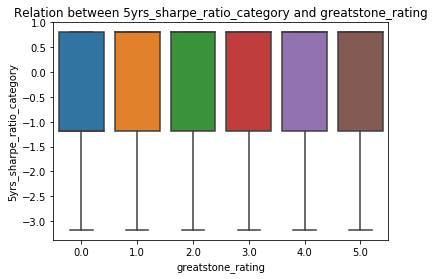

                         sum_sq       df          F        PR(>F)
greatstone_rating     87.942111      1.0  87.887869  7.644002e-21
Residual           20010.342321  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0    0.287  0.001  0.1782 0.3958   True
   0.0    2.0   0.2444  0.001  0.1557  0.333   True
   0.0    3.0   0.2998  0.001  0.2153 0.3842   True
   0.0    4.0   0.3279  0.001  0.2401 0.4156   True
   0.0    5.0   0.3432  0.001  0.2386 0.4477   True
   1.0    2.0  -0.0426 0.7164 -0.1309 0.0458  False
   1.0    3.0   0.0128    0.9 -0.0714  0.097  False
   1.0    4.0   0.0409 0.7394 -0.0466 0.1284  False
   1.0    5.0   0.0562 0.6219 -0.0481 0.1605  False
   2.0    3.0   0.0554 0.0532 -0.0004 0.1112  False
   2.0    4.0   0.0835 0.0012  0.0228 0.1441   True
   2.0    5.0   0.0988 0.0092  0.0157 0.1818   True
   3.0    4.0   0.0281

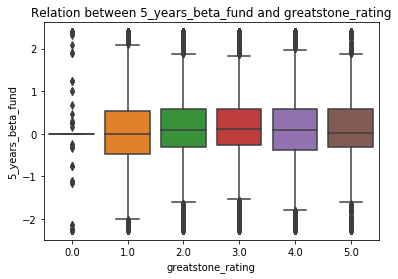

                         sum_sq       df         F    PR(>F)
greatstone_rating      5.604302      1.0  5.640141  0.017563
Residual           19870.923938  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0939  0.134 -0.0146 0.2024  False
   0.0    2.0   0.1063 0.0081  0.0179 0.1947   True
   0.0    3.0   0.1163 0.0012   0.032 0.2006   True
   0.0    4.0   0.0902 0.0389  0.0027 0.1777   True
   0.0    5.0   0.1232 0.0098   0.019 0.2274   True
   1.0    2.0   0.0124    0.9 -0.0757 0.1005  False
   1.0    3.0   0.0224    0.9 -0.0616 0.1064  False
   1.0    4.0  -0.0037    0.9 -0.0909 0.0836  False
   1.0    5.0   0.0293    0.9 -0.0747 0.1333  False
   2.0    3.0     0.01    0.9 -0.0456 0.0657  False
   2.0    4.0  -0.0161    0.9 -0.0766 0.0444  False
   2.0    5.0   0.0169    0.9 -0.0659 0.0997  False
   3.0    4.0  -0.0261  0.716 -0.0803

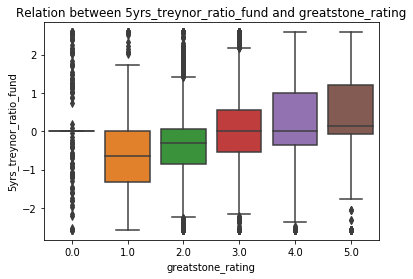

                         sum_sq       df            F         PR(>F)
greatstone_rating   1126.911966      1.0  1198.596902  4.021496e-255
Residual           18801.972083  19998.0          NaN            NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0    1.0  -0.7032 0.001 -0.8067 -0.5997   True
   0.0    2.0  -0.3528 0.001 -0.4371 -0.2685   True
   0.0    3.0   0.0112   0.9 -0.0691  0.0916  False
   0.0    4.0   0.2678 0.001  0.1843  0.3512   True
   0.0    5.0   0.4505 0.001  0.3511  0.5499   True
   1.0    2.0   0.3504 0.001  0.2663  0.4345   True
   1.0    3.0   0.7145 0.001  0.6344  0.7945   True
   1.0    4.0    0.971 0.001  0.8878  1.0542   True
   1.0    5.0   1.1537 0.001  1.0545  1.2529   True
   2.0    3.0    0.364 0.001   0.311  0.4171   True
   2.0    4.0   0.6206 0.001  0.5629  0.6782   True
   2.0    5.0   0.8033 0.001  0.7243  0.8823   True
   3.0    4.0

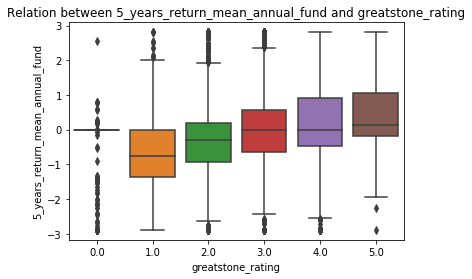

                         sum_sq       df           F  PR(>F)
greatstone_rating   1442.990683      1.0  1555.08513     0.0
Residual           18556.493870  19998.0         NaN     NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0    1.0  -0.5218 0.001 -0.6254 -0.4182   True
   0.0    2.0  -0.1249 0.001 -0.2093 -0.0405   True
   0.0    3.0   0.2333 0.001  0.1528  0.3137   True
   0.0    4.0    0.463 0.001  0.3794  0.5465   True
   0.0    5.0   0.6722 0.001  0.5727  0.7717   True
   1.0    2.0   0.3969 0.001  0.3127  0.4811   True
   1.0    3.0   0.7551 0.001  0.6749  0.8353   True
   1.0    4.0   0.9848 0.001  0.9015  1.0681   True
   1.0    5.0    1.194 0.001  1.0947  1.2933   True
   2.0    3.0   0.3582 0.001  0.3051  0.4113   True
   2.0    4.0   0.5879 0.001  0.5302  0.6456   True
   2.0    5.0   0.7971 0.001   0.718  0.8762   True
   3.0    4.0   0.2297 0.001   0.178 

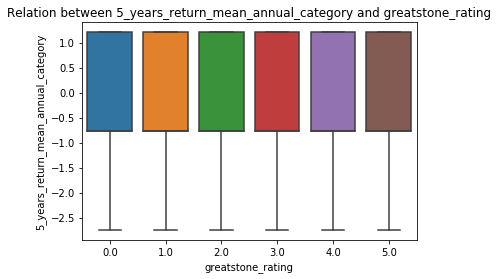

                         sum_sq       df         F    PR(>F)
greatstone_rating      1.587806      1.0  1.582864  0.208363
Residual           20060.444053  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.1136  0.035  0.0047  0.2225   True
   0.0    2.0   0.1624  0.001  0.0736  0.2511   True
   0.0    3.0   0.1899  0.001  0.1053  0.2744   True
   0.0    4.0   0.1246  0.001  0.0368  0.2125   True
   0.0    5.0    0.062 0.5329 -0.0426  0.1666  False
   1.0    2.0   0.0487 0.6022 -0.0397  0.1372  False
   1.0    3.0   0.0763 0.1025  -0.008  0.1605  False
   1.0    4.0    0.011    0.9 -0.0766  0.0986  False
   1.0    5.0  -0.0516 0.6954  -0.156  0.0528  False
   2.0    3.0   0.0275 0.6976 -0.0283  0.0834  False
   2.0    4.0  -0.0377 0.4848 -0.0984   0.023  False
   2.0    5.0  -0.1003 0.0077 -0.1834 -0.0172   True
   3.0    4.0  -0.0653

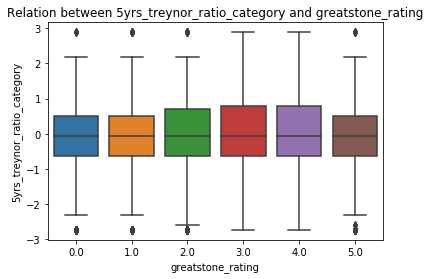

                         sum_sq       df         F    PR(>F)
greatstone_rating      0.001662      1.0  0.001675  0.967357
Residual           19841.462144  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.0243    0.9 -0.0841  0.1327  False
   0.0    2.0   0.0308    0.9 -0.0575  0.1192  False
   0.0    3.0   0.0799 0.0746 -0.0043   0.164  False
   0.0    4.0   0.0425 0.7084 -0.0449  0.1299  False
   0.0    5.0  -0.0387 0.8976 -0.1428  0.0654  False
   1.0    2.0   0.0065    0.9 -0.0815  0.0946  False
   1.0    3.0   0.0556 0.4112 -0.0283  0.1395  False
   1.0    4.0   0.0182    0.9 -0.0689  0.1054  False
   1.0    5.0   -0.063 0.5114 -0.1668  0.0409  False
   2.0    3.0    0.049 0.1202 -0.0065  0.1046  False
   2.0    4.0   0.0117    0.9 -0.0487  0.0721  False
   2.0    5.0  -0.0695 0.1582 -0.1522  0.0132  False
   3.0    4.0  -0.0374

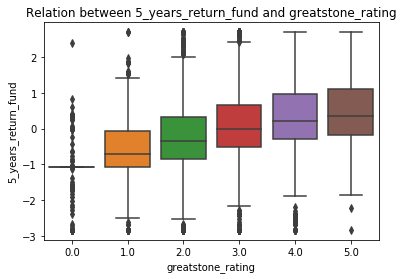

                         sum_sq       df           F  PR(>F)
greatstone_rating   3520.964248      1.0  4265.05915     0.0
Residual           16509.089453  19998.0         NaN     NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   0.0    1.0    0.523 0.001 0.4246 0.6214   True
   0.0    2.0   0.9222 0.001  0.842 1.0023   True
   0.0    3.0   1.2728 0.001 1.1965 1.3492   True
   0.0    4.0   1.5251 0.001 1.4458 1.6044   True
   0.0    5.0   1.6398 0.001 1.5453 1.7343   True
   1.0    2.0   0.3992 0.001 0.3192 0.4791   True
   1.0    3.0   0.7498 0.001 0.6737  0.826   True
   1.0    4.0   1.0021 0.001  0.923 1.0812   True
   1.0    5.0   1.1168 0.001 1.0225 1.2111   True
   2.0    3.0   0.3507 0.001 0.3002 0.4011   True
   2.0    4.0   0.6029 0.001 0.5481 0.6578   True
   2.0    5.0   0.7176 0.001 0.6425 0.7927   True
   3.0    4.0   0.2523 0.001 0.2031 0.3014   True
   3.0    5.0  

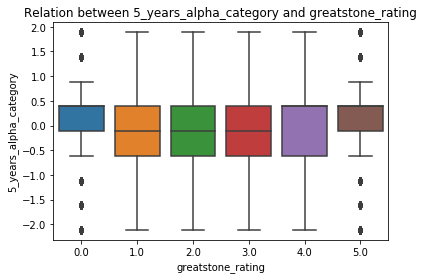

                         sum_sq       df         F    PR(>F)
greatstone_rating      0.048283      1.0  0.048384  0.825902
Residual           19956.253092  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.0937 0.1363 -0.2024  0.0149  False
   0.0    2.0  -0.1141 0.0033 -0.2027 -0.0256   True
   0.0    3.0  -0.1436  0.001 -0.2279 -0.0592   True
   0.0    4.0  -0.0756 0.1368 -0.1632  0.0121  False
   0.0    5.0  -0.0121    0.9 -0.1164  0.0923  False
   1.0    2.0  -0.0204    0.9 -0.1087  0.0679  False
   1.0    3.0  -0.0498 0.5341 -0.1339  0.0343  False
   1.0    4.0   0.0182    0.9 -0.0692  0.1056  False
   1.0    5.0   0.0817 0.2216 -0.0225  0.1858  False
   2.0    3.0  -0.0294 0.6402 -0.0851  0.0263  False
   2.0    4.0   0.0386 0.4568  -0.022  0.0991  False
   2.0    5.0   0.1021  0.006  0.0191   0.185   True
   3.0    4.0    0.068

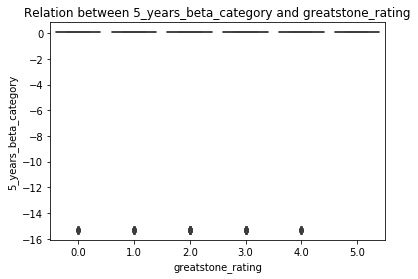

                         sum_sq       df          F        PR(>F)
greatstone_rating     26.003248      1.0  26.922694  2.138253e-07
Residual           19315.041918  19998.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0437 0.8359 -0.1507 0.0632  False
   0.0    2.0   0.0403 0.7473 -0.0468 0.1275  False
   0.0    3.0   0.0787 0.0758 -0.0044 0.1617  False
   0.0    4.0   0.0807 0.0829 -0.0056  0.167  False
   0.0    5.0    0.124 0.0077  0.0212 0.2268   True
   1.0    2.0   0.0841 0.0648 -0.0028  0.171  False
   1.0    3.0   0.1224  0.001  0.0396 0.2052   True
   1.0    4.0   0.1244  0.001  0.0384 0.2104   True
   1.0    5.0   0.1678  0.001  0.0652 0.2703   True
   2.0    3.0   0.0383  0.348 -0.0165 0.0932  False
   2.0    4.0   0.0403 0.3867 -0.0193 0.0999  False
   2.0    5.0   0.0837 0.0409   0.002 0.1653   True
   3.0    4.0    0.002

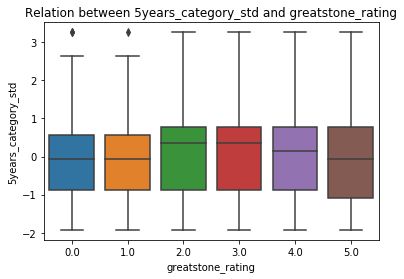

                         sum_sq       df         F    PR(>F)
greatstone_rating      0.222358      1.0  0.222448  0.637186
Residual           19989.903788  19998.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.0332    0.9 -0.1418  0.0755  False
   0.0    2.0   0.1049 0.0096  0.0163  0.1934   True
   0.0    3.0   0.1243  0.001    0.04  0.2087   True
   0.0    4.0   0.0534  0.506 -0.0342   0.141  False
   0.0    5.0  -0.0619 0.5331 -0.1662  0.0425  False
   1.0    2.0    0.138  0.001  0.0498  0.2263   True
   1.0    3.0   0.1575  0.001  0.0734  0.2416   True
   1.0    4.0   0.0866 0.0538 -0.0008  0.1739  False
   1.0    5.0  -0.0287    0.9 -0.1328  0.0754  False
   2.0    3.0   0.0195    0.9 -0.0363  0.0752  False
   2.0    4.0  -0.0515 0.1484  -0.112  0.0091  False
   2.0    5.0  -0.1667  0.001 -0.2497 -0.0838   True
   3.0    4.0  -0.0709

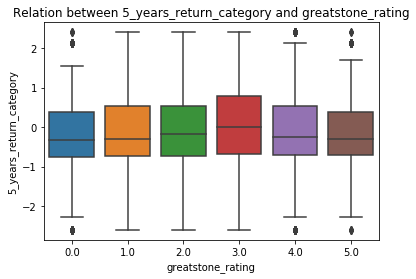

                         sum_sq       df          F   PR(>F)
greatstone_rating     15.758287      1.0  15.806216  0.00007
Residual           19937.360419  19998.0        NaN      NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.1511  0.001  0.0426  0.2597   True
   0.0    2.0   0.2007  0.001  0.1122  0.2892   True
   0.0    3.0    0.244  0.001  0.1597  0.3283   True
   0.0    4.0   0.1973  0.001  0.1098  0.2849   True
   0.0    5.0   0.1395 0.0019  0.0352  0.2438   True
   1.0    2.0   0.0496 0.5833 -0.0386  0.1378  False
   1.0    3.0   0.0929 0.0203  0.0089  0.1769   True
   1.0    4.0   0.0462 0.6373 -0.0411  0.1335  False
   1.0    5.0  -0.0116    0.9 -0.1157  0.0924  False
   2.0    3.0   0.0433 0.2304 -0.0124  0.0989  False
   2.0    4.0  -0.0034    0.9 -0.0639  0.0571  False
   2.0    5.0  -0.0612 0.2845 -0.1441  0.0217  False
   3.0    4.0  -0.0467

In [127]:
handle_return5year = HandleData('return_5year.csv')
handle_data_references.append(handle_return5year)
handle_return5year.read_data()
# handle_return3year.drop_columns(['fund_name'])
# handle_return3year.handle_categorydata(['currency', 'fund_size'])
handle_return5year.describe_data()
handle_return5year.handle_outliers()
handle_return5year.show_correlation(figsize = (10,10))
handle_return5year.handle_missingvalues()
handle_return5year.describe_data()
handle_return5year.show_pairwise()
if handle_return5year.check_correlation():
    print("Has correlation")
    print(handle_return5year.correlated_cols_list)
else:
    print('No correlation')

In [128]:
# handle_return5year.correlated_cols_list.append('5yrs_sharpe_ratio_fund')
# handle_return5year.correlated_cols_list.append('5_years_alpha_fund')
# handle_return5year.correlated_cols_list.append('5yrs_treynor_ratio_fund')
# handle_return5year.correlated_cols_list.append('5_years_return_mean_annual_fund')
# handle_return5year.correlated_cols_list.append('5_years_return_fund')
handle_return5year.correlated_cols_list

['5yrs_sharpe_ratio_fund',
 '5_years_alpha_fund',
 '5yrs_treynor_ratio_fund',
 '5_years_return_mean_annual_fund',
 '5_years_return_fund',
 '5yrs_sharpe_ratio_category',
 '5_years_alpha_category',
 '5_years_return_mean_annual_category',
 '5yrs_treynor_ratio_category',
 '5_years_return_category',
 '5_years_return_mean_annual_category',
 '5yrs_treynor_ratio_category',
 '5_years_return_category',
 '5_years_return_mean_annual_category',
 '5yrs_treynor_ratio_category',
 '5_years_return_category']

In [129]:
handle_return5year.df.columns

Index(['category_r_squared_5years', '5yrs_sharpe_ratio_fund',
       '5_years_alpha_fund', '5years_fund_r_squared', '5years_fund_std',
       '5yrs_sharpe_ratio_category', '5_years_beta_fund',
       '5yrs_treynor_ratio_fund', '5_years_return_mean_annual_fund',
       '5_years_return_mean_annual_category', '5yrs_treynor_ratio_category',
       '5_years_return_fund', '5_years_alpha_category',
       '5_years_beta_category', '5years_category_std', 'tag',
       '5_years_return_category', 'greatstone_rating'],
      dtype='object')

In [130]:
len(handle_data_references)

9

In [131]:
final_df = handle_fundratiosdata.df[['fund_id', 'greatstone_rating']]
final_df.head()

,fund_id,greatstone_rating
0,264614c6-5ac3-4146-ba26-1674b136cb40,NaN
1,f5ad58c2-fdea-4087-8678-e04744f89f90,3.0
2,3c13f4ab-02c4-4ca7-a133-7e996ec5d0c4,4.0
3,ff78bdd8-59eb-4cef-9f3c-b1baacce9554,3.0
4,63d8406d-c525-494a-8e03-d4fc4cfcb571,0.0


In [132]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
fund_id              25000 non-null object
greatstone_rating    20000 non-null float64
dtypes: float64(1), object(1)
memory usage: 390.7+ KB


In [133]:
final_df.shape

(25000, 2)

In [134]:
for reference in handle_data_references :
#   for col in reference.df.columns :
    for col in reference.correlated_cols_list :
#         if col != 'tag' :
        if col not in final_df.columns :
            final_df[col] = reference.df[col]
final_df.shape

C:\Users\home\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(25000, 68)

In [135]:
final_df.head()

,fund_id,greatstone_rating,fund_ratio_net_annual_expense,total_assets,return_ytd,years_up,ytd_return_fund,2014_return_fund,fund_return_3months,1_year_return_fund,...,5yrs_sharpe_ratio_fund,5_years_alpha_fund,5yrs_treynor_ratio_fund,5_years_return_mean_annual_fund,5_years_return_fund,5yrs_sharpe_ratio_category,5_years_alpha_category,5_years_return_mean_annual_category,5yrs_treynor_ratio_category,5_years_return_category
0,264614c6-5ac3-4146-ba26-1674b136cb40,NaN,1.44,1.185000e+07,20.19,1.0,20.19,5.073053,20.19,12.89,...,0.523744,-0.745933,4.530223,0.441754,0.00,-0.00,-0.05,-0.00,-0.04,-3.09
1,f5ad58c2-fdea-4087-8678-e04744f89f90,3.0,0.58,3.910455e+09,16.79,5.0,16.79,14.250000,16.79,12.18,...,0.890000,0.340000,10.370000,0.990000,11.71,0.01,-0.00,0.01,0.10,11.26
2,3c13f4ab-02c4-4ca7-a133-7e996ec5d0c4,4.0,0.99,2.660000e+09,17.13,25.5,17.13,11.040000,17.13,12.89,...,1.150000,2.960000,13.840000,1.050000,12.78,0.01,-0.00,0.01,0.10,11.26
3,ff78bdd8-59eb-4cef-9f3c-b1baacce9554,3.0,0.52,3.910455e+09,11.63,11.0,11.63,12.320000,11.63,7.11,...,0.770000,-0.500000,9.300000,0.620000,7.25,0.01,-0.03,0.01,0.07,7.20
4,63d8406d-c525-494a-8e03-d4fc4cfcb571,0.0,0.75,2.847000e+07,10.25,1.0,10.25,5.073053,10.25,3.11,...,0.523744,-0.745933,4.530223,0.441754,0.00,0.01,-0.01,0.01,0.04,5.95


In [136]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 68 columns):
fund_id                                25000 non-null object
greatstone_rating                      20000 non-null float64
fund_ratio_net_annual_expense          25000 non-null float64
total_assets                           25000 non-null float64
return_ytd                             25000 non-null float64
years_up                               25000 non-null float64
ytd_return_fund                        25000 non-null float64
2014_return_fund                       25000 non-null float64
fund_return_3months                    25000 non-null float64
1_year_return_fund                     25000 non-null float64
2015_return_fund                       25000 non-null float64
2016_return_fund                       25000 non-null float64
2011_return_fund                       25000 non-null float64
2010_return_fund                       25000 non-null float64
fund_return_3years      

In [137]:
final_df.to_csv('final_funds.csv', index = False)

In [138]:
data = pd.read_csv('final_funds.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 68 columns):
fund_id                                25000 non-null object
greatstone_rating                      20000 non-null float64
fund_ratio_net_annual_expense          25000 non-null float64
total_assets                           25000 non-null float64
return_ytd                             25000 non-null float64
years_up                               25000 non-null float64
ytd_return_fund                        25000 non-null float64
2014_return_fund                       25000 non-null float64
fund_return_3months                    25000 non-null float64
1_year_return_fund                     25000 non-null float64
2015_return_fund                       25000 non-null float64
2016_return_fund                       25000 non-null float64
2011_return_fund                       25000 non-null float64
2010_return_fund                       25000 non-null float64
fund_return_3years      